# Preface

In [1]:
%matplotlib inline
import getpass
import h5py
import itertools
import math
import numpy as np
import os
import pickle
import pyfits
import socket
import sys
import time

#require CosmoloPy
import cosmolopy.distance as cd
from scipy import integrate, interpolate
from scipy.optimize import curve_fit

if getpass.getuser()=='ssaito':
    HOMEDIR = '/Users/ssaito/'
    DIRNAME = '/Volumes/HD-PNFU3-Mac/sim/MDPL2/Rockstar/halocatalog/'
elif getpass.getuser()=='shsaito':
    HOMEDIR = '/Users/shsaito/'
    #DIRNAME = '/Volumes/MyBookThunderboltDuo/CosmoTreasure/mock/cosmos/'
    
##CONSTANTS
Gnewton = 4.302E-9 #Mpc/Msun(km/s)**2
SQDEGtoSTR = math.pi**2./32400
Mpctocm = 3.0857E+24

## Plot
import matplotlib.pyplot as plt
from matplotlib import ticker, patches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from ss_default_plot import *

## read subhalo catalog

In [2]:
#MDPL2 simulation
CP = {'omega_M_0':0.307115, 'omega_lambda_0':0.692885, 'omega_k_0':0.0, 'h':0.677700}
a_scale = 0.65650
z_red = 1./a_scale - 1.
KMpSECtoMPCpH = 1./a_scale/100./cd.e_z(z_red, **CP)
Lbox = 1000.

print 'redshift = ', z_red

arr_subhalos = pyfits.open(DIRNAME+'hlist_0.65650.list.all.Vpeakcut160.0.hostsubs.fits')[1].data

## check simulations
print 'total number of subhalos: {0}'.format(arr_subhalos.shape[0])
print '      number of hosts:    {0}'.format(np.where(arr_subhalos['upid']==-1)[0].shape[0])
print '      number of subhalos: {0}\n'.format(np.where(arr_subhalos['upid']!=-1)[0].shape[0])
print 'field includes:'
print arr_subhalos.names

redshift =  0.523229246002
total number of subhalos: 3834194
      number of hosts:    1214176
      number of subhalos: 2620018

field includes:
['id', 'upid', 'mvir', 'rvir', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Rs_Klypin', 'M200b', 'Mpeak', 'Vpeak', 'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn', 'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'Vmax@Mpeak', 'vz_host', 'Mhost', 'Vpeak_host', 'Rsub', 'Zchar', 'Zform', 'Zacc', 'Zstarve']


In [3]:
## read added values
arr_addvals = pyfits.open(DIRNAME+'hlist_0.65650.list.all.Vpeakcut160.0.hostsubs.Vprofile.fits')[1].data

## add values for velocity profile

In [5]:
## sort the subhalo catalog
dtype_addvals = np.dtype([('id', int), ('upid', int), ('sid', int), 
                          ('x', float), ('y', float), ('z', float), 
                          ('vx', float), ('vy', float), ('vz', float), 
                          ('Xsub', float), ('Ysub', float), ('Zsub', float), ('Rsub', float), 
                          ('V_r', float), ('V_theta', float), ('V_phi', float), 
                          ('mvir_sub', float), ('mvir_host', float), ('rvir_host', float),
                          ('cvir_host', float), ('Vvir_host', float)])
arr_addvals = np.zeros(shape=arr_subhalos.shape[0], dtype=dtype_addvals)

for name in ['id','upid','x','y','z','vx','vy','vz']:
    arr_addvals[name][:] = arr_subhalos[name][:]
arr_addvals['mvir_sub'][:] = arr_subhalos['mvir'][:]
#as for now, insert all subhalo values for host properties
arr_addvals['mvir_host'][:] = arr_subhalos['mvir'][:]
arr_addvals['rvir_host'][:] = arr_subhalos['rvir'][:]/1000. #[comoving Mpc/h]
arr_addvals['cvir_host'][:] = arr_subhalos['rvir'][:]/arr_subhalos['Rs_Klypin'][:]

#copy host id to sid to get a quick sort
arr_addvals['sid'][:] = arr_subhalos['upid'][:]
select_host = arr_addvals['sid']==-1
arr_addvals['sid'][select_host] = arr_addvals['id'][select_host]

#sort in terms of sid to collect a chunck of host-subhalos
arr_addvals.sort(order=('sid', 'upid'))
where_host = np.where(arr_addvals['upid']==-1)[0]

<Strong>Mapping from Cartesian to Spherical coordinate</Strong>

Positions:
\begin{eqnarray}
 X & = & r\sin\phi\cos\theta\\
 Y & = & r\sin\phi\sin\theta\\
 Z & = & r\cos\phi
\end{eqnarray}

Velocity: 
\begin{equation}
\vec{v} = \dot{r}\vec{e}_{r}+r\dot{\theta}\sin\phi\vec{e}_{\theta}+r\dot{\phi}\vec{e}_{\phi}
\end{equation}

where
\begin{eqnarray}
 v_{r} & = & \dot{r} = \frac{X v_{X}+Y v_{Y}+Z v_{Z}}{r}\\
 v_{\theta} & = & r\dot{\theta}\sin\phi = \frac{v_{Y}X-v_{X}Y}{\sqrt{X^{2}+Y^{2}}}\\
 v_{\phi} & = & r\dot{\phi} = \frac{Z(Xv_{X}+Yv_{Y})-(X^{2}+Y^{2})v_{Z}}{r\sqrt{X^{2}+Y^{2}}}
\end{eqnarray}

In [6]:
def conv_Vcart_to_Vsphe(x, y, z, v_x, v_y, v_z):
    v_r = np.zeros(shape=(x.shape[0],), dtype=np.float)
    v_phi = np.zeros(shape=(x.shape[0],), dtype=np.float)
    v_theta = np.zeros(shape=(x.shape[0],), dtype=np.float)
    
    r = (x**2.+y**2.+z**2.)**0.5
    
    # v_r = rdot
    v_r = (x*v_x + y*v_y + z*v_z)/r
    
    #taking care of the X=Y=0 case
    select_xy0 = np.logical_and(x==0., y==0.)
    v_theta[select_xy0] = 0.
    if z[select_xy0]>0:
        v_phi[select_xy0] = (v_x[select_xy0]**2.+v_y[select_xy0]**2.)**0.5
    else:
        v_phi[select_xy0] = -(v_x[select_xy0]**2.+v_y[select_xy0]**2.)**0.5

    # v_theta = thetadot * r * sin(phi)
    v_theta[~select_xy0] = (v_y[~select_xy0]*x[~select_xy0] - v_x[~select_xy0]*y[~select_xy0])/(x[~select_xy0]**2.+y[~select_xy0]**2.)**0.5
    
    # v_phi = r * phidot
    v_phi[~select_xy0] = (z[~select_xy0]*(x[~select_xy0]*v_x[~select_xy0]+y[~select_xy0]*v_y[~select_xy0]) - v_z[~select_xy0]*(x[~select_xy0]**2.+y[~select_xy0]**2.))/r/(x[~select_xy0]**2.+y[~select_xy0]**2.)**0.5
    
    return v_r, v_theta, v_phi

In [7]:
%%time

for ihost in np.arange(where_host.shape[0]-1):
    indx_thishost = where_host[ihost]
    indx_nexthost = where_host[ihost+1]
    
    Xsub = arr_addvals['x'][indx_thishost+1:indx_nexthost] - arr_addvals['x'][indx_thishost]
    Ysub = arr_addvals['y'][indx_thishost+1:indx_nexthost] - arr_addvals['y'][indx_thishost]
    Zsub = arr_addvals['z'][indx_thishost+1:indx_nexthost] - arr_addvals['z'][indx_thishost]
    #taking care of periodic boundary condition
    where_Xsub_toolow = Xsub[:] < -10.
    Xsub[where_Xsub_toolow] += Lbox
    where_Xsub_toohigh = Xsub[:] > 10.
    Xsub[where_Xsub_toohigh] -= Lbox
    where_Ysub_toolow = Ysub[:] < -10.
    Ysub[where_Ysub_toolow] += Lbox
    where_Ysub_toohigh = Ysub[:] > 10.
    Ysub[where_Ysub_toohigh] -= Lbox
    where_Zsub_toolow = Zsub[:] < -10.
    Zsub[where_Zsub_toolow] += Lbox
    where_Zsub_toohigh = Zsub[:] > 10.
    Zsub[where_Zsub_toohigh] -= Lbox
    
    # host property
    arr_addvals['mvir_host'][indx_thishost+1:indx_nexthost] = arr_addvals['mvir_host'][indx_thishost]
    arr_addvals['rvir_host'][indx_thishost+1:indx_nexthost] = arr_addvals['rvir_host'][indx_thishost]
    arr_addvals['cvir_host'][indx_thishost+1:indx_nexthost] = arr_addvals['cvir_host'][indx_thishost]
    # rvir in Rockstar is comoving => should convert to physical to get physical km/s
    arr_addvals['Vvir_host'][indx_thishost+1:indx_nexthost] = np.sqrt(Gnewton*arr_addvals['mvir_host'][indx_thishost]
                                                                      /arr_addvals['rvir_host'][indx_thishost]/a_scale)
    
    
    # cartesian coordinate [Mpc/h]
    arr_addvals['Xsub'][indx_thishost+1:indx_nexthost] = Xsub
    arr_addvals['Ysub'][indx_thishost+1:indx_nexthost] = Ysub
    arr_addvals['Zsub'][indx_thishost+1:indx_nexthost] = Zsub
    arr_addvals['Rsub'][indx_thishost+1:indx_nexthost] = (Xsub**2.+Ysub**2.+Zsub**2.)**0.5
    
    # convert velocity [km/s] to [Mpc/h] 
    V_Xsub = (arr_addvals['vx'][indx_thishost+1:indx_nexthost] - arr_addvals['vx'][indx_thishost])*KMpSECtoMPCpH
    V_Ysub = (arr_addvals['vy'][indx_thishost+1:indx_nexthost] - arr_addvals['vy'][indx_thishost])*KMpSECtoMPCpH
    V_Zsub = (arr_addvals['vz'][indx_thishost+1:indx_nexthost] - arr_addvals['vz'][indx_thishost])*KMpSECtoMPCpH
    
    V_r, V_theta, V_phi = conv_Vcart_to_Vsphe(Xsub, Ysub, Zsub, V_Xsub, V_Ysub, V_Zsub)
    # now convert back to [km/s]
    arr_addvals['V_r'][indx_thishost+1:indx_nexthost] = V_r/KMpSECtoMPCpH
    arr_addvals['V_theta'][indx_thishost+1:indx_nexthost] = V_theta/KMpSECtoMPCpH
    arr_addvals['V_phi'][indx_thishost+1:indx_nexthost] = V_phi/KMpSECtoMPCpH

CPU times: user 2min 43s, sys: 585 ms, total: 2min 44s
Wall time: 2min 44s


In [8]:
#save into fits file
Save_FitsColumns = pyfits.ColDefs([pyfits.Column(name='id', format='i8'),
                                   pyfits.Column(name='upid', format='i8'),
                                   pyfits.Column(name='sid', format='i8'),
                                   pyfits.Column(name='Xsub', format='f8'),
                                   pyfits.Column(name='Ysub', format='f8'),
                                   pyfits.Column(name='Zsub', format='f8'),
                                   pyfits.Column(name='Rsub', format='f8'),
                                   pyfits.Column(name='V_r', format='f8'),
                                   pyfits.Column(name='V_phi', format='f8'),
                                   pyfits.Column(name='V_theta', format='f8'), 
                                   pyfits.Column(name='mvir_sub', format='f8'),
                                   pyfits.Column(name='mvir_host', format='f8'),
                                   pyfits.Column(name='rvir_host', format='f8'),
                                   pyfits.Column(name='cvir_host', format='f8'),
                                   pyfits.Column(name='Vvir_host', format='f8')])

MYCOMMENTS = []
MYCOMMENTS.append("gerenrated by check_Jeans.ipynb")

tmptbhdu = pyfits.new_table(Save_FitsColumns, nrows=arr_addvals.shape[0])
for name in tmptbhdu.columns.names:
    tmptbhdu.data.field(name)[:] = arr_addvals[name][:]

tmppmhdu = pyfits.PrimaryHDU()
for i in xrange(len(MYCOMMENTS)):
    tmppmhdu.header.add_comment(MYCOMMENTS[i])

tmphdulist = pyfits.HDUList([tmppmhdu, tmptbhdu])
savefile = DIRNAME+'hlist_0.65650.list.all.Vpeakcut160.0.hostsubs.Vprofile.fits'
tmphdulist.writeto(savefile, clobber=True)
print 'catalog fits file is saved into', savefile

/Users/ssaito/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:21: PyfitsDeprecationWarning: The new_table function is deprecated as of version 3.3 and may be removed in a future version.

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.
/Users/ssaito/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file '/Volumes/HD-PNFU3-Mac/sim/MDPL2/Rockstar/halocatalog/hlist_0.65650.list.all.Vpeakcut160.0.hostsubs.Vprofile.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


catalog fits file is saved into /Volumes/HD-PNFU3-Mac/sim/MDPL2/Rockstar/halocatalog/hlist_0.65650.list.all.Vpeakcut160.0.hostsubs.Vprofile.fits


# Jeans equation

In the case of Spherical Equilibrium Model, the Jeans equation is described as follows.
See e.g., [Wojtak+(2005)](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:astro-ph/0503391).

\begin{equation}
 \frac{d}{dr}\left\{\rho(r)\sigma_{r}^{2}(r)\right\}+\frac{2\beta}{r}\rho(r)\sigma_{r}^{2}(r)
 +\rho(r)\frac{d\Phi}{dr} = 0, 
\end{equation}
where $\rho(r)$ and $\sigma_{r}(r)$ are the density and radial velocity dipersion profile of the tracer population. 

In the NFW halo, the gravitational potential is simple given by
\begin{equation}
 \frac{\Phi(s)}{V^{2}_{\rm vir}} = -g(c)\frac{\ln(1+cs)}{s}, 
\end{equation}
where $s=r/r_{\rm vir}$, $g(c)=[\ln(1+c)-c/(1+c)]^{-1}$, and $V^{2}_{\rm vir}=GM_{\rm vir}/r_{\rm vir}$. 

In this case the Jeans equation is rewritten as
\begin{equation}
 -\frac{d\Phi}{ds}\frac{1}{V_{\rm vir}^{2}} = \frac{1}{\rho(s)}\frac{d}{ds}\left\{\rho(s)\frac{\sigma_{r}^{2}(s)}{V_{\rm vir}^{2}}\right\}+\frac{2\beta}{s}\left\{\frac{\sigma_{r}^{2}(s)}{V_{\rm vir}^{2}}\right\}.
\end{equation}

**anisotropy parameter**

\begin{equation}
  \beta = 1-\frac{\sigma_{\phi}^{2}+\sigma_{\theta}^{2}}{2\sigma_{r}^{2}}
\end{equation}

**The necessary conditions for spherical equilibrium**
\begin{eqnarray}
 &&\langle v_{r}\rangle = \langle v_{\theta}\rangle = \langle v_{\phi}\rangle = 0\\
 &&\langle v_{r}v_{\theta}\rangle = \langle v_{r}v_{\phi}\rangle = \langle v_{\theta}v_{\phi}\rangle = 0\\
\end{eqnarray}

In the case of constant $\beta$, one has
\begin{equation}
  \frac{\sigma_{r}(r)^{2}}{V_{\rm vir}^{2}} = -\frac{s^{-2\beta}}{\rho(s)}\int^{\infty}_{s}dq\,q^{2\beta}\rho(q)
  g(c)\left[\frac{c}{q(1+cq)}-\frac{\ln(1+cq)}{q^2}\right]
\end{equation}

Now if one allows the infall motion in the system, i.e., $\langle v_{r}\rangle < 0$, there are two additional terms 
in the Jeans equation (See e.g., [Falco+(2013)](https://arxiv.org/abs/1306.6637)):
\begin{equation}
 -\frac{d\Phi}{ds}\frac{1}{V_{\rm vir}^{2}} = \frac{1}{\rho(s)}\frac{d}{ds}\left\{\rho(s)\frac{\sigma_{r}^{2}(s)}{V_{\rm vir}^{2}}\right\}+\frac{2\beta}{s}\left\{\frac{\sigma_{r}^{2}(s)}{V_{\rm vir}^{2}}\right\}
 +\frac{\langle v_{r}\rangle(s)}{V^{2}_{\rm vir}}\frac{d\langle v_{r}\rangle(s)}{ds}
 +\frac{r_{\rm vir}}{V_{\rm vir}^{2}}\frac{d\langle v_{r}\rangle(s)}{dt}.
\end{equation}

## Defining useful function

In [4]:
# define NFW-related function
def rhoNFW_unnormalized(r, c):
    return 1./r/(1.+c*r)**2.

def func_g(c):
    return 1./(np.log(1.+c)-c/(1.+c))

def func_minus_dPhids_perVvir2(s, c):
    return func_g(c)*(c*s/(1.+c*s)-np.log(1.+c*s))/s**2.

# See Jian & van den Bosch (2017)
def phi_sub(x, mu=2., eta=4.):
    return (2.**mu)*x**eta/(1.+x)**mu

## First attempt

Just for the first attempt, select host halos with Mhost > 10^13.5 Msun/h and subhalos hosted by them.

Warning: the subhalo catalog only includes Vpeak > 160 km/s

In [30]:
select = arr_subhalos['Mhost'] >= 10.**13.5
arr_tmp = arr_subhalos[select]

select = np.in1d(arr_addvals['id'], arr_tmp['id'])
arr_addvals_tmp = arr_addvals[select]

In [31]:
print 'total number of subhalos: {0}'.format(arr_addvals_tmp.shape[0])
print '      number of hosts:    {0}'.format(np.where(arr_addvals_tmp['upid']==-1)[0].shape[0])
print '      number of subhalos: {0}\n'.format(np.where(arr_addvals_tmp['upid']!=-1)[0].shape[0])

total number of subhalos: 822351
      number of hosts:    75886
      number of subhalos: 746465



In [124]:
#radial binning setting
num_logRbins = 100
dlogR = (0.5+2.)/num_logRbins
bins_logR = np.array([-2. + dlogR*i for i in xrange(num_logRbins+1)])
meds_logR = np.array([(bins_logR[i]+bins_logR[i+1])/2. for i in xrange(num_logRbins)])
vol_logR = np.array([4.*np.pi*(10**bins_logR[i+1])**3./3. - 4.*np.pi*(10**bins_logR[i])**3./3. 
                     for i in xrange(num_logRbins)])

**radial profile of subhalos**

In [16]:
dndlogR = np.zeros(shape=(num_logRbins,3))
for ibin in xrange(num_logRbins):
    dndlogR[ibin,0] = meds_logR[ibin]
    
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logR[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logR[ibin+1])
    
    dndlogR[ibin,1] = float(arr_addvals_tmp[select].shape[0])/vol_logR[ibin]/dlogR/75886.
    dndlogR[ibin,2] = float(arr_addvals_tmp[select].shape[0])**0.5/vol_logR[ibin]/dlogR/75886.

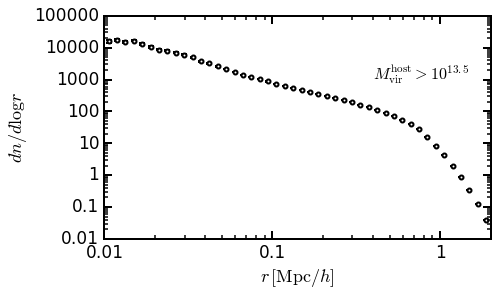

In [17]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-2,1.E5)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$r\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$dn/d\log r$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.4, 1000., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

#ax.plot(arr_zp06['OII_obs'][:], arr_zp06['OII_obs_itn'][:]*arr_zp06['ape_subaru']/arr_zp06['OII_obs'][:], 'rx', ms=3)
#ax.plot(arr_zp06['OII_obs'][:], arr_zp06['OII_obs_itn'][:]/arr_zp06['OII_obs'][:], 'bx', ms=3)


plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

**velocity profile**

In [18]:
stat_vel = np.zeros(shape=(num_logRbins,6))
for ibin in xrange(num_logRbins):
    stat_vel[ibin,0] = meds_logR[ibin]
    
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logR[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logR[ibin+1])
    
    stat_vel[ibin,1] = arr_addvals_tmp[select]['V_r'].mean()
    stat_vel[ibin,2] = arr_addvals_tmp[select]['V_r'].std()
    stat_vel[ibin,3] = (arr_addvals_tmp[select]['V_phi'].std()**2.+arr_addvals_tmp[select]['V_theta'].std()**2.)**0.5
    stat_vel[ibin,4] = arr_addvals_tmp[select]['V_phi'].mean()
    stat_vel[ibin,5] = arr_addvals_tmp[select]['V_theta'].mean()

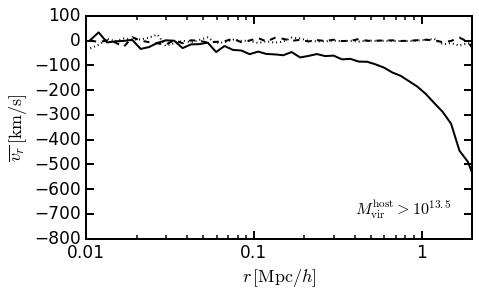

In [19]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$r\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$\overline{v_{r}}\,[{\rm km/s}]$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)


ax.plot(10.**stat_vel[:,0], stat_vel[:,1], 'k-', lw=2, label=r'$v_{r}$')
ax.plot(10.**stat_vel[:,0], stat_vel[:,4], 'k--', lw=2, label=r'$v_{\phi}$')
ax.plot(10.**stat_vel[:,0], stat_vel[:,5], 'k:', lw=2, label=r'$v_{\theta}$')


#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

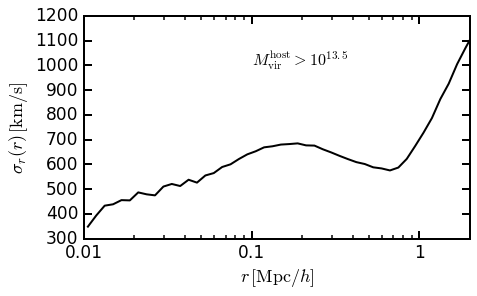

In [24]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$r\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$\sigma_{r}(r)\,[{\rm km/s}]$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.1, 1000., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)


ax.plot(10.**stat_vel[:,0], stat_vel[:,2], 'k-', lw=2)


#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

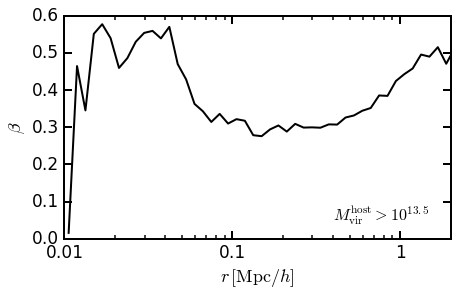

In [25]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$r\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$\beta$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.4, 0.05, r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)


ax.plot(10.**stat_vel[:,0], 1.-stat_vel[:,3]**2./2./stat_vel[:,2]**2., 'k-', lw=2)


#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

## Second buggy attempt

In [16]:
select_Mhost = arr_subhalos['Mhost'] >= 10.**13.5
## avoid incompleteness
select_Mratio = arr_subhalos['mvir']/arr_subhalos['Mhost']>1.e-5
select = np.logical_and(select_Mhost, select_Mratio)
arr_tmp = arr_subhalos[select]

select = np.in1d(arr_addvals['id'], arr_tmp['id'])
select_sub = np.logical_and(select, arr_addvals['upid']!=-1)
arr_addvals_tmp = arr_addvals[select_sub]

print '# of subhalos:', arr_addvals_tmp.shape[0]
print '# of hosts:',arr_tmp[arr_tmp['upid']==-1].shape[0]
num_host = arr_tmp[arr_tmp['upid']==-1].shape[0]

## check mean concentration
c_mean = np.unique(arr_addvals_tmp['cvir_host'][:]).mean()
print c_mean, arr_addvals_tmp['cvir_host'][:].mean()

#mean subhalo mass
mvir_mean_sub = arr_addvals_tmp['mvir_sub'].mean()
print mvir_mean_sub

# of subhalos: 746456
# of hosts: 75886
5.25629124055 5.01605780723
1.23347447249e+12


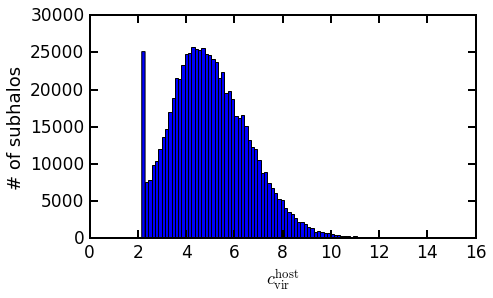

In [17]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.,16.)
#ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(MultipleLocator(0.1))
#ax.set_ylim(0.,5.)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$c^{\rm host}_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'# of subhalos', fontsize=18)
#ax.set_title(r'velocity dispersion profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.hist(arr_addvals_tmp['cvir_host'], bins=100)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/hist_zacc.png')
plt.show()

In [10]:
# dynamical time
from colossus.cosmology import cosmology
from colossus.halo.mass_so import dynamicalTime
cosmo = cosmology.setCosmology('planck15')
print 't_dyn_crossing [Gyr] =', dynamicalTime(z_red, mdef='vir', definition='crossing')
print 't_dyn_orbit [Gyr]    =', dynamicalTime(z_red, mdef='vir', definition='orbit')
print '\n'
print 't_dyn_crossing [Gyr] =', dynamicalTime(1., mdef='vir', definition='crossing')
print 't_dyn_orbit [Gyr]    =', dynamicalTime(1., mdef='vir', definition='orbit')
print '\n'
print 't(0.523<z<0.66)[Gyr] =',(cd.age(z_red, **CP)-cd.age(0.66, **CP))/3.15E16
print 't(0.523<z<0.82)[Gyr] =',(cd.age(z_red, **CP)-cd.age(0.82, **CP))/3.15E16
print 't(0.523<z<1.08)[Gyr] =',(cd.age(z_red, **CP)-cd.age(1.08, **CP))/3.15E16

t_dyn_crossing [Gyr] = 2.58406736098
t_dyn_orbit [Gyr]    = 8.11808703764


t_dyn_crossing [Gyr] = 1.8270791121
t_dyn_orbit [Gyr]    = 5.73993831611


t(0.523<z<0.66)[Gyr] = 0.895133658826
t(0.523<z<0.82)[Gyr] = 1.77113985871
t(0.523<z<1.08)[Gyr] = 2.89438912178


In [6]:
#first rescale with rvir and Vvir
arr_addvals_tmp['Rsub'][:] = arr_addvals_tmp['Rsub'][:]/arr_addvals_tmp['rvir_host'][:]
arr_addvals_tmp['V_r'][:] = arr_addvals_tmp['V_r'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_phi'][:] = arr_addvals_tmp['V_phi'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_theta'][:] = arr_addvals_tmp['V_theta'][:]/arr_addvals_tmp['Vvir_host'][:]

In [12]:
#radial binning setting
num_logsbins = 50
dlogs = (0.5+2.)/num_logsbins
bins_logs = np.array([-2.025 + dlogs*i for i in xrange(num_logsbins+1)])
meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
meds_s = 10.**meds_logs[:]
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

In [7]:
#adoptive binning around r_vir
num_logsbins = 38 + 10
dlogs_1 = 0.05
dlogs_2 = 0.0125

bins_logs = np.zeros(shape=(num_logsbins+1,))
for ibin in xrange(num_logsbins+1):
    if ibin <= 38:
        bins_logs[ibin] = -2.025 + dlogs_1*ibin
    else:
        bins_logs[ibin] = -0.125 + dlogs_2*(ibin-38)

meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
meds_s = 10.**meds_logs[:]
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

### rescaled profile

In [22]:
n_of_s = np.zeros(shape=(num_logsbins))
rho_of_s = np.zeros(shape=(num_logsbins, 2))
v_mean = np.zeros(shape=(num_logsbins,3))
v_std = np.zeros(shape=(num_logsbins,3))
v_rms = np.zeros(shape=(num_logsbins,3))
beta_std = np.zeros(shape=(num_logsbins))
beta_rms = np.zeros(shape=(num_logsbins))

for ibin in xrange(num_logsbins):
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logs[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logs[ibin+1])
    
    n_of_s[ibin] = float(arr_addvals_tmp[select].shape[0])/float(num_host)/vol_logs[ibin]
    rho_of_s[ibin, 0] = np.sum(arr_addvals_tmp[select]['mvir_sub'])/float(num_host)/vol_logs[ibin]
    rho_of_s[ibin, 1] = np.sqrt(np.sum(arr_addvals_tmp[select]['mvir_sub']))/float(num_host)/vol_logs[ibin]
    
    v_mean[ibin, 0] = arr_addvals_tmp[select]['V_r'].mean()
    v_mean[ibin, 1] = arr_addvals_tmp[select]['V_theta'].mean()
    v_mean[ibin, 2] = arr_addvals_tmp[select]['V_phi'].mean()
    
    v_std[ibin, 0] = arr_addvals_tmp[select]['V_r'].std()
    v_std[ibin, 1] = arr_addvals_tmp[select]['V_theta'].std()
    v_std[ibin, 2] = arr_addvals_tmp[select]['V_phi'].std()
    
    v_rms[ibin, 0] = (arr_addvals_tmp[select]['V_r']**2.).mean()
    v_rms[ibin, 1] = (arr_addvals_tmp[select]['V_theta']**2.).mean()
    v_rms[ibin, 2] = (arr_addvals_tmp[select]['V_phi']**2.).mean()
    
    beta_std[ibin] = 1.-(v_std[ibin, 1]**2.+v_std[ibin, 2]**2.)/2./v_std[ibin, 0]**2.
    beta_rms[ibin] = 1.-(v_rms[ibin, 1]**2.+v_rms[ibin, 2]**2.)/2./v_rms[ibin, 0]**2.

In [12]:
Norm_NFW = rho_of_s[46,0]/rhoNFW_unnormalized(1., c_mean)

In [41]:
#check mass of subhalos
mvir_mean_sub_sbin = np.zeros(shape=(num_logsbins))

#print 's=r/r_vir, # of subhalos, average subhalo mass'
for ibin in xrange(num_logsbins):
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logs[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logs[ibin+1])
    
    mvir_mean_sub_sbin[ibin] = np.average(arr_addvals_tmp[select]['mvir_sub'])
    #print 10.**meds_logs[ibin], arr_addvals_tmp[select].shape[0], np.log10(np.average(arr_addvals_tmp[select]['mvir_sub']))

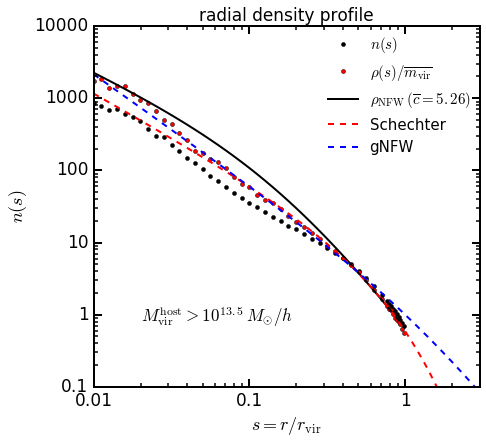

In [16]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
#golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,3.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-1,1.E4)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$n(s)$', fontsize=18)
ax.set_title(r'radial density profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.02, 0.8, r'$M^{\rm host}_{\rm vir}>10^{13.5}\,M_{\odot}/h$', fontsize=17)

ax.plot(10.**meds_logs, n_of_s, 'ko', ms=4, label=r'$n(s)$')
ax.plot(10.**meds_logs, rho_of_s[:,0]/mvir_mean_sub, 'ro', ms=4, label=r'$\rho(s)/\overline{m_{\rm vir}}$')
#ax.plot(10.**meds_logs, drhodlogs/mvir_mean_sub_sbin, 'bo-', ms=4, label=r'$\rho(s)/\overline{M_{\rm vir}(s)}$')

ax.plot(10.**meds_logs, Norm_NFW*rhoNFW_unnormalized(meds_s, c_mean)/mvir_mean_sub, 'k-', lw=2, 
       label=r'$\rho_{\rm NFW}\,(\overline{c}=5.26)$')

arr_s = 10.**np.array([-2.+0.02*i for i in xrange(151)])
ax.plot(arr_s, Schechter_rho_of_s(arr_s, -2.21187851, 0.49123886)/mvir_mean_sub, 
        'r--', lw=2, label=r'Schechter')
ax.plot(arr_s, gNFW_rho_of_s(arr_s, 1.52827074, 9.44768273)/mvir_mean_sub, 
        'b--', lw=2, label=r'gNFW')


axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/all_radial-density.png')
plt.show()

** try to find a smooth function for the radial profile  **

- generalized NFW doesn't work => But outer profile should -3 so gNFW should be adopted.

In [15]:
np.where(meds_s>=0.1)[0]

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [80]:
popt, pcov = curve_fit(gNFW_rho_of_s, meds_s[20:], rho_of_s[20:,0], bounds=([0., 0.], [3., 100.]))
print popt

[ 1.52827074  9.44768273]


In [15]:
from scipy.optimize import curve_fit
def Schechter_rho_of_s(s, alpha, s0):
    func = 10.**((alpha+1.)*(np.log10(s)-np.log10(s0)))*np.log(10)*np.exp(-s/s0)
    pivot_num = 20
    s_pivot = meds_s[pivot_num]
    func_s_at_pivot = 10.**((alpha+1.)*(np.log10(s_pivot)-np.log10(s0)))*np.log(10)*np.exp(-s_pivot/s0)
    norm = rho_of_s[pivot_num, 0]/func_s_at_pivot
    return func*norm

popt, pcov = curve_fit(Schechter_rho_of_s, meds_s[20:], rho_of_s[20:,0], sigma=rho_of_s[20:,1], bounds=([-3., 0.1], [3., 1.]))
print popt

[-2.21187851  0.49123886]


In [30]:
popt, pcov = curve_fit(Schechter_rho_of_s, meds_s[20:], rho_of_s[20:,0], sigma=rho_of_s[20:,1], bounds=([-3., 0.1], [3., 1.]))
print popt

[-2.21187851  0.49123886]


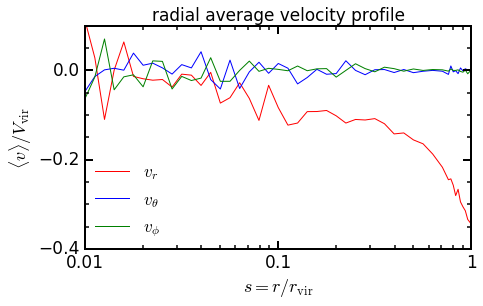

In [251]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(-0.4,0.1)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\langle v\rangle /V_{\rm vir}$', fontsize=18)
ax.set_title(r'radial average velocity profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(10.**meds_logs, v_mean[:, 0], 'r-', ms=4, label=r'$v_{r}$')
ax.plot(10.**meds_logs, v_mean[:, 1], 'b-', ms=4, label=r'$v_{\theta}$')
ax.plot(10.**meds_logs, v_mean[:, 2], 'g-', ms=4, label=r'$v_{\phi}$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower left', numpoints=1, 
                  ncol=1, fontsize=17, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/all_radial-avevel.png')
plt.show()

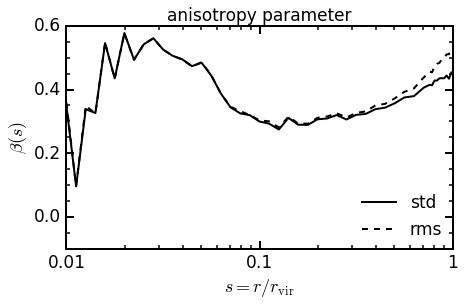

In [54]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(-0.1,0.6)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\beta(s)$', fontsize=18)
ax.set_title(r'anisotropy parameter', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(10.**meds_logs, 1.-(v_std[:, 1]**2.+v_std[:, 2]**2.)/2./v_std[:, 0]**2., 'k-', lw=2, label=r'std')
ax.plot(10.**meds_logs, 1.-(v_rms[:, 1]+v_rms[:, 2])/2./v_rms[:, 0], 'k--', lw=2, label=r'rms')
#ax.plot(10.**meds_logs, v_mean[:, 1], 'b-', ms=4, label=r'$v_{\theta}$')
#ax.plot(10.**meds_logs, v_mean[:, 2], 'g-', ms=4, label=r'$v_{\phi}$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower right', numpoints=1, 
                  ncol=1, fontsize=17, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/all_beta.png')
plt.show()

In [254]:
v_cov = np.zeros(shape=(num_logsbins, 3))

for ibin in xrange(num_logsbins):
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logs[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logs[ibin+1])
    
    #v_mean[ibin, 0] = arr_addvals_tmp[select]['V_r'].mean()
    #v_mean[ibin, 1] = arr_addvals_tmp[select]['V_theta'].mean()
    #v_mean[ibin, 2] = arr_addvals_tmp[select]['V_phi'].mean()
    
    #r, theta
    v_cov[ibin, 0] = np.sum( (arr_addvals_tmp[select]['V_r']-v_mean[ibin, 0])
                            *(arr_addvals_tmp[select]['V_theta']-v_mean[ibin, 1]))/float(arr_addvals_tmp[select].shape[0]-1)
    #r, phi
    v_cov[ibin, 1] = np.sum( (arr_addvals_tmp[select]['V_r']-v_mean[ibin, 0])
                            *(arr_addvals_tmp[select]['V_phi']-v_mean[ibin, 2]))/float(arr_addvals_tmp[select].shape[0]-1)    
    
    #theta, phi
    v_cov[ibin, 2] = np.sum( (arr_addvals_tmp[select]['V_theta']-v_mean[ibin, 1])
                            *(arr_addvals_tmp[select]['V_phi']-v_mean[ibin, 2]))/float(arr_addvals_tmp[select].shape[0]-1)

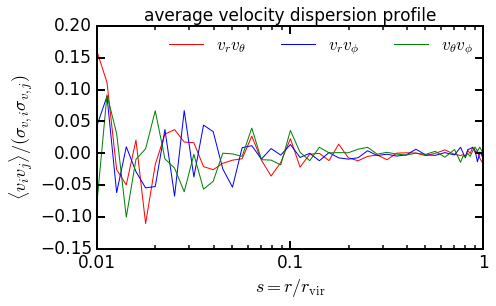

In [255]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(-1.,0.2)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.2))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\langle v_{i}v_{j}\rangle /(\sigma_{v,i}\sigma_{v,j})$', fontsize=18)
ax.set_title(r'average velocity dispersion profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(10.**meds_logs, v_cov[:, 0]/v_std[:, 0]/v_std[:, 1], 'r-', ms=4, label=r'$v_{r}v_{\theta}$')
ax.plot(10.**meds_logs, v_cov[:, 1]/v_std[:, 0]/v_std[:, 2], 'b-', ms=4, label=r'$v_{r}v_{\phi}$')
ax.plot(10.**meds_logs, v_cov[:, 2]/v_std[:, 1]/v_std[:, 2], 'g-', ms=4, label=r'$v_{\theta}v_{\phi}$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=3, fontsize=17, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/all_velcorr.png')
plt.show()

### differential equation

#### the 1st-week version (faliure...)

In [90]:
dndlogs = np.zeros(shape=(num_logsbins))
sig_vr = np.zeros(shape=(num_logsbins))
beta = np.zeros(shape=(num_logsbins))

for ibin in xrange(num_logsbins):
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logs[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logs[ibin+1])
    
    dndlogs[ibin] = float(arr_addvals_tmp[select].shape[0])/vol_logs[ibin]/dlogs/75886.
    sig_vr[ibin] = arr_addvals_tmp[select]['V_r'].std()
    beta[ibin] = 1.-(arr_addvals_tmp[select]['V_phi'].std()**2.+arr_addvals_tmp[select]['V_theta'].std()**2.)/2.*sig_vr[ibin]**2.

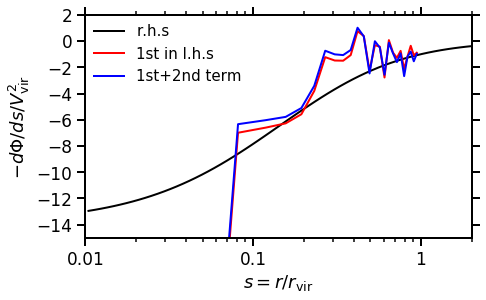

In [91]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
ax.set_ylim(-15.,2.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$-d\Phi/ds/V_{\rm vir}^{2}$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, 0.05, r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)


#ax.plot(10.**stat_vel[:,0], 1.-stat_vel[:,3]**2./2./stat_vel[:,2]**2., 'k-', lw=2)

c_mean = 5.2562912405461422
ax.plot(10.**meds_logs[:], func_minus_dPhids_perVvir2(10.**meds_logs[:], c_mean), 'k-', lw=2, label='r.h.s')

arr_1st_term = np.zeros(shape=(num_logsbins-2,2))
arr_2nd_term = np.zeros(shape=(num_logsbins-2))
for i in xrange(num_logsbins-2):
    arr_1st_term[i, 0] = meds_logs[i+1]
    arr_1st_term[i, 1] = (dndlogs[i+2]*sig_vr[i+2]**2.-dndlogs[i]*sig_vr[i]**2.)/(10.**meds_logs[i+2]-10.**meds_logs[i])/dndlogs[i+1]
    arr_2nd_term[i] = 2.*sig_vr[i+1]**2.*beta[i+1]/10.**meds_logs[i+1]
ax.plot(arr_1st_term[:,0], arr_1st_term[:,1], 'r-', lw=2, label='1st in l.h.s')
ax.plot(arr_1st_term[:,0], arr_1st_term[:,1]+arr_2nd_term[:], 'b-', lw=2, label='1st+2nd term')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='upper left', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

#### numerically more stable treatment

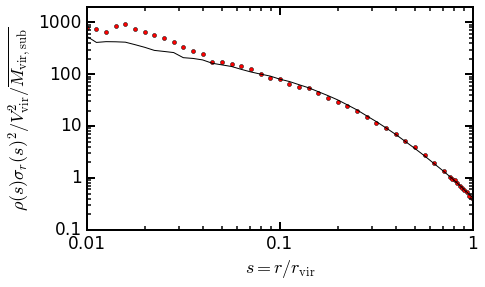

In [38]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-1,2.E3)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\rho(s)\sigma_{r}(s)^{2}/V_{\rm vir}^{2}/\overline{M_{\rm vir,sub}}$', fontsize=18)
#ax.set_title(r'radial density profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, 1000., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

#ax.plot(meds_s, 10.**func_rhosigrsq_smooth(meds_logs)/mvir_mean_sub, 'k-', lw=1)
ax.plot(meds_s, rho_of_s[:,0]*v_std[:,0]**2./mvir_mean_sub, 'ro', ms=4)
ax.plot(meds_s, Schechter_rho_of_s(meds_s, -2.21187851, 0.49123886)*v_std[:,0]**2./mvir_mean_sub, 'k-', lw=1)
#ax.plot(10.**meds_logs, drhodlogs/mvir_mean_sub_sbin, 'bo-', ms=4, label=r'$\rho(s)/\overline{M_{\rm vir}(s)}$')

#axleg = ax.legend(loc='lower left', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

In [22]:
import scipy.interpolate as ip

def get_smoothfunc(arr_D):
    func_inpspl = ip.InterpolatedUnivariateSpline(meds_logs, arr_D)
    sx = np.linspace(-2., 0., 70)
    sy = func_inpspl(sx)
    knots = np.array([-1.9+0.2*i for i in xrange(10)])
    return ip.LSQUnivariateSpline(sx,sy,knots)

In [117]:
import scipy.interpolate as ip
func_log_rhosigrsq_smooth = ip.InterpolatedUnivariateSpline(meds_logs[:], 
                                                            gNFW_rho_of_s(meds_s, 1.52827074, 9.44768273)*v_std[:,0]**2.)
func_rho_of_s_smooth = lambda x: gNFW_rho_of_s(x, 1.52827074, 9.44768273)

func_vr_smooth = get_smoothfunc(v_mean[:,0])

arr_1st_term = np.zeros(shape=(num_logsbins))
arr_2nd_term = np.zeros(shape=(num_logsbins))
arr_3rd_term = np.zeros(shape=(num_logsbins))
for ibin in xrange(num_logsbins):
    dlogs = 0.0001
    arr_1st_term[ibin] = (func_log_rhosigrsq_smooth(meds_logs[ibin]+dlogs/2.)
                          -func_log_rhosigrsq_smooth(meds_logs[ibin]-dlogs/2.))/dlogs/meds_s[ibin]/func_rho_of_s_smooth(meds_s[ibin])/np.log(10.)
    
    #arr_2nd_term[ibin] = 2.*func_betasigrsq_smooth(meds_logs[ibin])/meds_s[ibin]
    arr_2nd_term[ibin] = 2.*beta[ibin]*v_std[ibin,0]**2./meds_s[ibin]
    
    arr_3rd_term[ibin] = (func_vr_smooth(meds_logs[ibin]+dlogs/2.)
                          -func_vr_smooth(meds_logs[ibin]-dlogs/2.))/dlogs/meds_s[ibin]/np.log(10.)*func_vr_smooth(meds_logs[ibin])

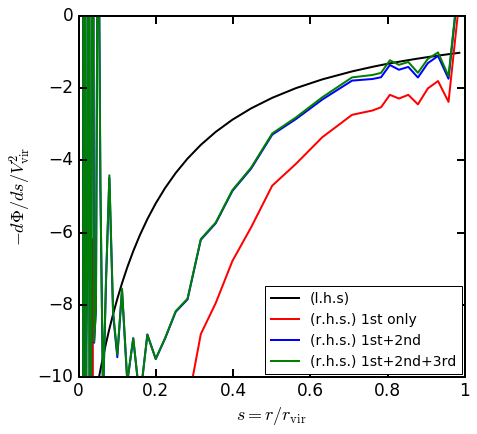

In [118]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
ax.set_ylim(-10.,0.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$-d\Phi/ds/V_{\rm vir}^{2}$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, 0.05, r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)
#ax.plot(10.**stat_vel[:,0], 1.-stat_vel[:,3]**2./2./stat_vel[:,2]**2., 'k-', lw=2)

c_mean = 5.2562912405461422
ax.plot(10.**meds_logs[:], func_minus_dPhids_perVvir2(10.**meds_logs[:], c_mean), 'k-', lw=2, label='(l.h.s)')

ax.plot(10.**meds_logs[:], arr_1st_term[:], 'r-', lw=2, label='(r.h.s.) 1st only')
#ax.plot(10.**meds_logs[:], arr_2nd_term[:], 'b--', lw=2, label='(r.h.s.) 2nd only')
ax.plot(10.**meds_logs[:], arr_1st_term[:]+arr_2nd_term[:], 'b-', lw=2, label='(r.h.s.) 1st+2nd')
ax.plot(10.**meds_logs[:], arr_1st_term[:]+arr_2nd_term[:]+arr_3rd_term[:], 
        'g-', lw=2, label='(r.h.s.) 1st+2nd+3rd')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower right', numpoints=1, 
                  ncol=1, fontsize=14, borderaxespad=0.2)
axleg.draw_frame(True)

#plt.savefig(HOMEDIR+'Desktop/all_diff_Jeans_lin.png')
plt.show()

### integrated formula

In [18]:
def integrand_NFW(q, beta, c):
    integrand = q**(2.*beta) * rhoNFW_unnormalized(q, c) * func_g(c)
    integrand *= -(1./q/(1.+c*q) - np.log(1.+c*q)/q**2.)
    return integrand

def integrand_Schechter(q, beta, c):
    integrand = q**(2.*beta) * Schechter_rho_of_s(q, -2.21187851, 0.49123886) * func_g(c)
    integrand *= -(c/q/(1.+c*q) - np.log(1.+c*q)/q**2.)
    return integrand

def integrand_gNFW(q, beta, c):
    integrand = q**(2.*beta) * gNFW_rho_of_s(q, 1.52827074, 9.44768273) * func_g(c)
    integrand *= -(c/q/(1.+c*q) - np.log(1.+c*q)/q**2.)
    return integrand

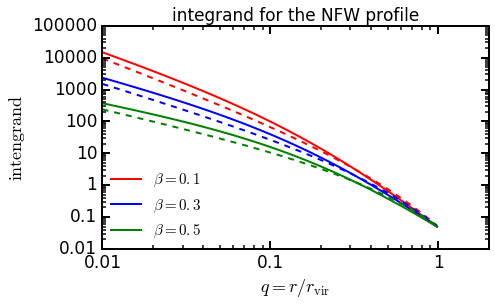

In [68]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
#ax.set_ylim(-20.,0.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$q=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\rm intengrand$', fontsize=18)
ax.set_title(r'integrand for the NFW profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, 0.05, r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)
#ax.plot(10.**stat_vel[:,0], 1.-stat_vel[:,3]**2./2./stat_vel[:,2]**2., 'k-', lw=2)

c_mean = 5.
beta = 0.1
ax.plot(meds_s, integrand_NFW(meds_s, beta, c_mean), 'r-', lw=2, label=r'$\beta=0.1$')
ax.plot(meds_s, integrand_Schechter(meds_s, beta, c_mean)/mvir_mean_sub/20., 'r--', lw=2)

c_mean = 5.
beta = 0.3
ax.plot(meds_s, integrand_NFW(meds_s, beta, c_mean), 'b-', lw=2, label=r'$\beta=0.3$')
ax.plot(meds_s, integrand_Schechter(meds_s, beta, c_mean)/mvir_mean_sub/20., 'b--', lw=2)

c_mean = 5.
beta = 0.5
ax.plot(meds_s, integrand_NFW(meds_s, beta, c_mean), 'g-', lw=2, label=r'$\beta=0.5$')
ax.plot(meds_s, integrand_Schechter(meds_s, beta, c_mean)/mvir_mean_sub/20., 'g--', lw=2)


#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower left', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

In [20]:
beta_mean = 0.
func_intgd_Schechter = lambda x: integrand_Schechter(x, beta_mean, c_mean)
func_intgd_gNFW = lambda x: integrand_gNFW(x, beta_mean, c_mean)

arr_itg_constbeta = np.zeros(shape=(num_logsbins,))
arr_itg_constgNFW = np.zeros(shape=(num_logsbins,))

arr_itg_varbeta = np.zeros(shape=(num_logsbins,))
arr_itg_varbeta_gNFW = np.zeros(shape=(num_logsbins,))
for ibin in xrange(num_logsbins):
    arr_itg_constbeta[ibin] = integrate.quad(func_intgd_Schechter, meds_s[ibin], 100.)[0]/Schechter_rho_of_s(meds_s[ibin], -2.21187851, 0.49123886)*meds_s[ibin]**(-2.*beta_mean)
    arr_itg_constgNFW[ibin] = integrate.quad(func_intgd_gNFW, meds_s[ibin], 100.)[0]/gNFW_rho_of_s(meds_s[ibin], 1.52827074, 9.44768273)*meds_s[ibin]**(-2.*beta_mean)
    func_intgd_var = lambda x: integrand_Schechter(x, beta[ibin], c_mean)
    arr_itg_varbeta[ibin] = integrate.quad(func_intgd_var, meds_s[ibin], 100.)[0]/Schechter_rho_of_s(meds_s[ibin], -2.21187851, 0.49123886)*meds_s[ibin]**(-2.*beta[ibin])
    func_intgd_var = lambda x: integrand_gNFW(x, beta[ibin], c_mean)
    arr_itg_varbeta_gNFW[ibin] = integrate.quad(func_intgd_var, meds_s[ibin], 100.)[0]/gNFW_rho_of_s(meds_s[ibin], 1.52827074, 9.44768273)*meds_s[ibin]**(-2.*beta[ibin])

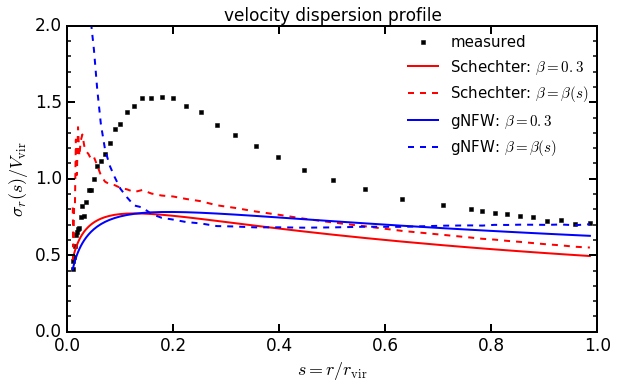

In [63]:
fig_width_pt = 700                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(0.,2.)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\sigma_{r}(s)/V_{\rm vir}$', fontsize=18)
ax.set_title(r'velocity dispersion profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(meds_s, v_std[:, 0]**2., 'ks', ms=4, label=r'measured')

ax.plot(meds_s, np.sqrt(arr_itg_constbeta[:]), 'r-', lw=2, label=r'Schechter: $\beta=0.3$')
ax.plot(meds_s, np.sqrt(arr_itg_varbeta[:]), 'r--', lw=2, label=r'Schechter: $\beta=\beta(s)$')
ax.plot(meds_s, np.sqrt(arr_itg_constgNFW[:]), 'b-', lw=2, label=r'gNFW: $\beta=0.3$')
ax.plot(meds_s, np.sqrt(arr_itg_varbeta_gNFW[:]), 'b--', lw=2, label=r'gNFW: $\beta=\beta(s)$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/all_jeans_prediction_lin.png')
plt.show()

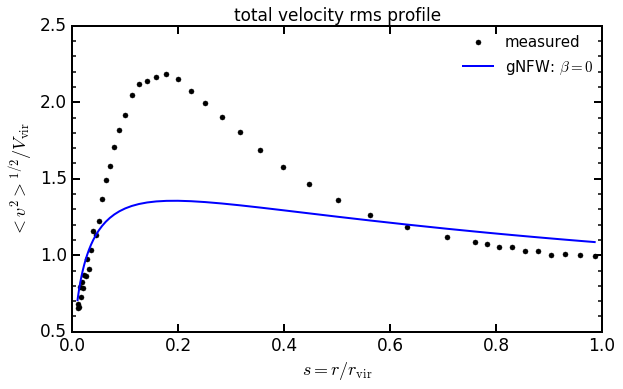

In [25]:
fig_width_pt = 700                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(0.,2.)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$<v^{2}>^{1/2}/V_{\rm vir}$', fontsize=18)
ax.set_title(r'total velocity rms profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

#ax.plot(meds_s, np.sqrt(v_std[:, 0]**2.+v_std[:, 2]**2.+v_std[:, 2]**2.), 'ks', ms=5, label=r'measured')
ax.plot(meds_s, np.sqrt(v_rms[:, 0]**2.+v_rms[:, 2]**2.+v_rms[:, 2]**2.), 'ko', ms=5, label=r'measured')

#ax.plot(meds_s, np.sqrt(arr_itg_constbeta[:]), 'r-', lw=2, label=r'Schechter: $\beta=0.3$')
#ax.plot(meds_s, np.sqrt(arr_itg_varbeta[:]), 'r--', lw=2, label=r'Schechter: $\beta=\beta(s)$')
ax.plot(meds_s, np.sqrt(3.*arr_itg_constgNFW[:]), 'b-', lw=2, label=r'gNFW: $\beta=0$')
#ax.plot(meds_s, np.sqrt(arr_itg_varbeta_gNFW[:]), 'b--', lw=2, label=r'gNFW: $\beta=\beta(s)$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/all_jeans_prediction_lin.png')
plt.show()

## Jeans equation for narrow mass bin

### test and debug with JL and APH

In [11]:
select_Mhost = arr_subhalos['Mhost'] > 10.**13.5 #, arr_subhalos['Mhost'] < 10.**13.75)
## avoid incompleteness
select_Mratio = arr_subhalos['Mpeak']> 4.5e11
select = np.logical_and(select_Mhost, select_Mratio)
arr_tmp = arr_subhalos[select]

select = np.in1d(arr_addvals['id'], arr_tmp['id'])
select_sub = np.logical_and(select, arr_addvals['upid']!=-1)
arr_addvals_tmp = arr_addvals[select_sub]

print '# of subhalos:', arr_addvals_tmp.shape[0]
print '# of hosts:',arr_tmp[arr_tmp['upid']==-1].shape[0]
num_host = arr_tmp[arr_tmp['upid']==-1].shape[0]

## check mean concentration
c_mean = np.unique(arr_addvals_tmp['cvir_host'][:]).mean()
print 'mean concentration of host halos:', c_mean, arr_addvals_tmp['cvir_host'][:].mean()

#mean subhalo mass
mvir_mean_sub = arr_addvals_tmp['mvir_sub'].mean()
print mvir_mean_sub

# of subhalos: 562706
# of hosts: 75886
mean concentration of host halos: 5.24489065907 4.99650171308
1.59136508256e+12


In [12]:
#first rescale with rvir and Vvir
arr_addvals_tmp['Rsub'][:] = arr_addvals_tmp['Rsub'][:]/arr_addvals_tmp['rvir_host'][:]
arr_addvals_tmp['V_r'][:] = arr_addvals_tmp['V_r'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_phi'][:] = arr_addvals_tmp['V_phi'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_theta'][:] = arr_addvals_tmp['V_theta'][:]/arr_addvals_tmp['Vvir_host'][:]

In [37]:
indx_host = np.where(arr_subhalos['id']==9607548566)[0][0]
print arr_subhalos['x'][indx_host], arr_subhalos['y'][indx_host], arr_subhalos['z'][indx_host]
print arr_subhalos['vx'][indx_host], arr_subhalos['vy'][indx_host], arr_subhalos['vz'][indx_host], '\n'

indx_sub = np.where(arr_subhalos['id']==9607548561)[0][0]
print arr_subhalos['x'][indx_sub], arr_subhalos['y'][indx_sub], arr_subhalos['z'][indx_sub]
print arr_subhalos['vx'][indx_sub], arr_subhalos['vy'][indx_sub], arr_subhalos['vz'][indx_sub], '\n'

dx = (arr_subhalos['x'][indx_sub]-arr_subhalos['x'][indx_host])*a_scale
dy = (arr_subhalos['y'][indx_sub]-arr_subhalos['y'][indx_host])*a_scale
dz = (arr_subhalos['z'][indx_sub]-arr_subhalos['z'][indx_host])*a_scale

dvx = arr_subhalos['vx'][indx_sub]-arr_subhalos['vx'][indx_host]
dvy = arr_subhalos['vy'][indx_sub]-arr_subhalos['vy'][indx_host]
dvz = arr_subhalos['vz'][indx_sub]-arr_subhalos['vz'][indx_host]

r = np.sqrt(dx**2.+dy**2.+dz**2.)
print 'r_sub [physical Mpc/h] = ', r

vr = (dx*dvx+dy*dvy+dz*dvz)/r
print "Shun's v_r [km/s] = ", vr
print "APH's  v_r [km/s] = 596.419909351"

5.46241 57.49893 22.9697
-119.72 20.69 -400.73 

4.87401 56.84055 23.33042
47.58 825.1 -564.74 

r_sub [physical Mpc/h] =  0.626191471496
Shun's v_r [km/s] =  -720.470297817
APH's  v_r [km/s] = 596.419909351


In [13]:
#adoptive binning around r_vir
num_logsbins = 38 + 10
dlogs_1 = 0.05
dlogs_2 = 0.0125

bins_logs = np.zeros(shape=(num_logsbins+1,))
for ibin in xrange(num_logsbins+1):
    if ibin <= 38:
        bins_logs[ibin] = -2.025 + dlogs_1*ibin
    else:
        bins_logs[ibin] = -0.125 + dlogs_2*(ibin-38)

meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
meds_s = 10.**meds_logs[:]
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

In [15]:
#radial binning setting
num_logsbins = 50
dlogs = (0.5+2.)/num_logsbins
bins_logs = np.array([-2.025 + dlogs*i for i in xrange(num_logsbins+1)])
meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
meds_s = 10.**meds_logs[:]
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

In [16]:
n_of_s = np.zeros(shape=(num_logsbins))
rho_of_s = np.zeros(shape=(num_logsbins, 2))
v_mean = np.zeros(shape=(num_logsbins,3))
v_std = np.zeros(shape=(num_logsbins,3))
beta = np.zeros(shape=(num_logsbins))

for ibin in xrange(num_logsbins):
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logs[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logs[ibin+1])
    
    n_of_s[ibin] = float(arr_addvals_tmp[select].shape[0])/float(num_host)/vol_logs[ibin]
    rho_of_s[ibin, 0] = np.sum(arr_addvals_tmp[select]['mvir_sub'])/float(num_host)/vol_logs[ibin]
    rho_of_s[ibin, 1] = np.sqrt(np.sum(arr_addvals_tmp[select]['mvir_sub']))/float(num_host)/vol_logs[ibin]
    
    v_mean[ibin, 0] = arr_addvals_tmp[select]['V_r'].mean()
    v_mean[ibin, 1] = arr_addvals_tmp[select]['V_theta'].mean()
    v_mean[ibin, 2] = arr_addvals_tmp[select]['V_phi'].mean()
    
    v_std[ibin, 0] = arr_addvals_tmp[select]['V_r'].std()
    v_std[ibin, 1] = arr_addvals_tmp[select]['V_theta'].std()
    v_std[ibin, 2] = arr_addvals_tmp[select]['V_phi'].std()
    
    beta[ibin] = 1.-(v_std[ibin, 1]**2.+v_std[ibin, 2]**2.)/2./v_std[ibin, 0]**2.

In [134]:
np.where(meds_s>=0.1)[0]

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [16]:
popt, pcov = curve_fit(gNFW_rho_of_s, meds_s[20:], rho_of_s[20:,0], bounds=([0., 0.], [3., 1.E13]))
print popt

[  1.66708190e+00   5.37716844e+11]


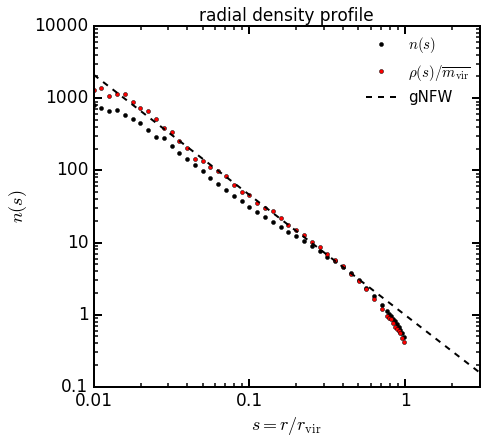

In [17]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
#golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,3.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-1,1.E4)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$n(s)$', fontsize=18)
ax.set_title(r'radial density profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.02, 0.8, r'$M^{\rm host}_{\rm vir}>10^{13.5}\,M_{\odot}/h$', fontsize=17)

ax.plot(10.**meds_logs, n_of_s, 'ko', ms=4, label=r'$n(s)$')
ax.plot(10.**meds_logs, rho_of_s[:,0]/mvir_mean_sub, 'ro', ms=4, label=r'$\rho(s)/\overline{m_{\rm vir}}$')
#ax.plot(10.**meds_logs, drhodlogs/mvir_mean_sub_sbin, 'bo-', ms=4, label=r'$\rho(s)/\overline{M_{\rm vir}(s)}$')

arr_s = 10.**np.array([-2.+0.02*i for i in xrange(151)])
ax.plot(arr_s, gNFW_rho_of_s(arr_s, 1.66708190e+00, 5.37716844e+11)/mvir_mean_sub, 
        'k--', lw=2, label=r'gNFW')


axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/all_radial-density.png')
plt.show()

In [18]:
def integrand_gNFW(q, beta, c):
    integrand = q**(2.*beta) * gNFW_rho_of_s(q, 1.66708190e+00, 5.37716844e+11) * func_g(c)
    integrand *= -(c/q/(1.+c*q) - np.log(1.+c*q)/q**2.)
    return integrand

In [19]:
beta_mean = 0.
func_intgd_Schechter = lambda x: integrand_Schechter(x, beta_mean, c_mean)
func_intgd_gNFW = lambda x: integrand_gNFW(x, beta_mean, c_mean)

arr_itg_constgNFW = np.zeros(shape=(num_logsbins,))
arr_itg_varbeta_gNFW = np.zeros(shape=(num_logsbins,))
for ibin in xrange(num_logsbins):
    
    arr_itg_constgNFW[ibin] = integrate.quad(func_intgd_gNFW, meds_s[ibin], 100.)[0]/gNFW_rho_of_s(meds_s[ibin], 1.66708190e+00, 5.37716844e+11)*meds_s[ibin]**(-2.*beta_mean)
    
    func_intgd_var = lambda x: integrand_gNFW(x, beta[ibin], c_mean)
    arr_itg_varbeta_gNFW[ibin] = integrate.quad(func_intgd_var, meds_s[ibin], 100.)[0]/gNFW_rho_of_s(meds_s[ibin], 1.66708190e+00, 5.37716844e+11)*meds_s[ibin]**(-2.*beta[ibin])

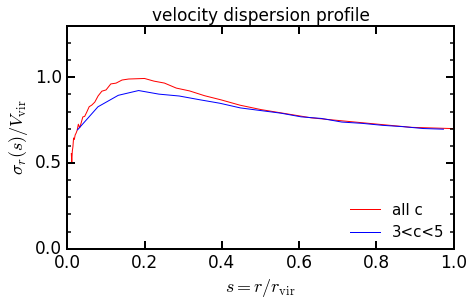

In [27]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(0.,1.3)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\sigma_{r}(s)/V_{\rm vir}$', fontsize=18)
ax.set_title(r'velocity dispersion profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.2, 0.3, r'$10^{14}<M^{\rm host}_{\rm vir}<10^{14.5}$', fontsize=16)

ax.plot(meds_s, v_std[:, 0], 'r-', lw=1, label=r'all c')

arr_JL = np.zeros(shape=(19,3))
arr_JL[:,0] = np.array([0.02631579,0.07894737,0.13157895,0.18421053,0.23684211,0.28947368,
                         0.34210526,0.39473684,0.44736842,0.5       ,0.55263158,0.60526316,
                         0.65789474,0.71052632,0.76315789,0.81578947,0.86842105,0.92105263,0.97368421])

arr_JL[:,1] = np.array([0.71844361,0.88495235,0.97578311, 0.99158711, 0.97099896, 0.93901665, 
                        0.90279146,0.87291379,0.8403502,0.81394016,0.79577855,0.77492893,
                        0.7624296,0.74948164,0.73643989,0.724437,0.71483785,0.70562121,0.69318207])

arr_JL[:,2] = np.array([0.69399492,0.82790165,0.89488976,0.92278495,0.90182184,0.89087142,
                        0.86924687,0.8486846 ,0.82166371,0.80622636,0.79085801,0.76933981,
                        0.75998085,0.73899827,0.73145934,0.71995535,0.71228009,0.70133911,0.69746079])

ax.plot(arr_JL[:,0], arr_JL[:, 2], 'b-', lw=1, label=r'3<c<5')

#ax.plot(meds_s, np.sqrt(arr_itg_constgNFW[:]), 'b-', lw=2, label=r'gNFW: $\beta=0$')
#ax.plot(meds_s, np.sqrt(arr_itg_varbeta_gNFW[:]), 'b--', lw=2, label=r'gNFW: $\beta=\beta(s)$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/all_jeans_prediction_lin.png')
plt.show()

In [21]:
arr_JL.shape

(2, 19)

### Mhost and c_vir

In [205]:
select_Mhost = arr_subhalos['Mhost'] > 10.**13.5 #, arr_subhalos['Mhost'] < 10.**13.75)
## avoid incompleteness
select_Mratio = arr_subhalos['Mpeak']> 4.5e11
select = np.logical_and(select_Mhost, select_Mratio)
arr_tmp = arr_subhalos[select]

select = np.in1d(arr_addvals['id'], arr_tmp['id'])
select_sub = np.logical_and(select, arr_addvals['upid']!=-1)
## concentration 
select_cvir = np.logical_and(arr_addvals['cvir_host'] > 4., arr_addvals['cvir_host'] < 7.)
select = np.logical_and(select_sub, select_cvir)
arr_addvals_tmp = arr_addvals[select]

print '# of subhalos:', arr_addvals_tmp.shape[0]
print '# of hosts:',arr_tmp[arr_tmp['upid']==-1].shape[0]
num_host = arr_tmp[arr_tmp['upid']==-1].shape[0]

## check mean concentration
c_mean_sub  = arr_addvals_tmp['cvir_host'][:].mean()
c_mean_host = np.unique(arr_addvals_tmp['cvir_host'][:]).mean()
c_medi_host = np.median(np.unique(arr_addvals_tmp['cvir_host'][:]))
print 'mean concentration of subhalos weighted:', c_mean_sub
print 'mean concentration of host halos weighted', c_mean_host
print 'median concentration of host halos weighted', c_medi_host

#mean subhalo mass
mvir_mean_sub = arr_addvals_tmp['mvir_sub'].mean()
print 'mean subhalo virial mass [Msun/h] =', mvir_mean_sub

#first rescale with rvir and Vvir
arr_addvals_tmp['Rsub'][:] = arr_addvals_tmp['Rsub'][:]/arr_addvals_tmp['rvir_host'][:]
arr_addvals_tmp['V_r'][:] = arr_addvals_tmp['V_r'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_phi'][:] = arr_addvals_tmp['V_phi'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_theta'][:] = arr_addvals_tmp['V_theta'][:]/arr_addvals_tmp['Vvir_host'][:]

# of subhalos: 335362
# of hosts: 75886
mean concentration of subhalos weighted: 5.29611877757
mean concentration of host halos weighted 5.37581779258
median concentration of host halos weighted 5.32573747242
mean subhalo virial mass [Msun/h] = 1.43519331265e+12


In [206]:
#adoptive binning around r_vir
num_logsbins = 38 + 10
dlogs_1 = 0.05
dlogs_2 = 0.0125

bins_logs = np.zeros(shape=(num_logsbins+1,))
for ibin in xrange(num_logsbins+1):
    if ibin <= 38:
        bins_logs[ibin] = -2.025 + dlogs_1*ibin
    else:
        bins_logs[ibin] = -0.125 + dlogs_2*(ibin-38)

meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
meds_s = 10.**meds_logs[:]
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

In [168]:
#radial binning setting
num_logsbins = 50
dlogs = (0.5+2.)/num_logsbins
bins_logs = np.array([-2.025 + dlogs*i for i in xrange(num_logsbins+1)])
meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
meds_s = 10.**meds_logs[:]
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

In [207]:
n_of_s = np.zeros(shape=(num_logsbins))
rho_of_s = np.zeros(shape=(num_logsbins, 2))
v_mean = np.zeros(shape=(num_logsbins,3))
v_std = np.zeros(shape=(num_logsbins,3))
v_rms = np.zeros(shape=(num_logsbins,3))
beta_std = np.zeros(shape=(num_logsbins))
beta_rms = np.zeros(shape=(num_logsbins))

for ibin in xrange(num_logsbins):
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logs[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logs[ibin+1])
    
    n_of_s[ibin] = float(arr_addvals_tmp[select].shape[0])/float(num_host)/vol_logs[ibin]
    rho_of_s[ibin, 0] = np.sum(arr_addvals_tmp[select]['mvir_sub'])/float(num_host)/vol_logs[ibin]
    rho_of_s[ibin, 1] = np.sqrt(np.sum(arr_addvals_tmp[select]['mvir_sub']))/float(num_host)/vol_logs[ibin]
    
    v_mean[ibin, 0] = arr_addvals_tmp[select]['V_r'].mean()
    v_mean[ibin, 1] = arr_addvals_tmp[select]['V_theta'].mean()
    v_mean[ibin, 2] = arr_addvals_tmp[select]['V_phi'].mean()
    
    v_std[ibin, 0] = arr_addvals_tmp[select]['V_r'].std()
    v_std[ibin, 1] = arr_addvals_tmp[select]['V_theta'].std()
    v_std[ibin, 2] = arr_addvals_tmp[select]['V_phi'].std()
    
    v_rms[ibin, 0] = (arr_addvals_tmp[select]['V_r']**2.).mean()
    v_rms[ibin, 1] = (arr_addvals_tmp[select]['V_theta']**2.).mean()
    v_rms[ibin, 2] = (arr_addvals_tmp[select]['V_phi']**2.).mean()
    
    beta_std[ibin] = 1.-(v_std[ibin, 1]**2.+v_std[ibin, 2]**2.)/2./v_std[ibin, 0]**2.
    beta_rms[ibin] = 1.-(v_rms[ibin, 1]+v_rms[ibin, 2])/2./v_rms[ibin, 0]

In [ ]:
def gNFW_rho_of_s(s, gamma, calR, c = 5., msubvir_mean = 1.e12, pivot_num = 20):
    func = (c*s/calR)**(-gamma) * (1.+c*s/calR)**(gamma-3.)
    s_pivot = meds_s[pivot_num]
    func_s_at_pivot = (c*s_pivot/calR)**(-gamma) * (1.+c*s_pivot/calR)**(gamma-3.)
    norm = rho_of_s[pivot_num,0]/func_s_at_pivot/msubvir_mean
    return func*norm*msubvir_mean

In [141]:
np.where(meds_s>=0.1)[0]

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [208]:
piv_point = 20
func_gNFW_rho_of_s = lambda x, gamma, calR: gNFW_rho_of_s(x, gamma, calR, c_mean_sub, mvir_mean_sub, piv_point)
popt, pcov = curve_fit(func_gNFW_rho_of_s, meds_s[piv_point:], rho_of_s[piv_point:,0], bounds=([0., 0.], [3., 10.]))
print popt
gamma_bf = popt[0]
calR_bf  = popt[1]

[ 1.3639299   7.05963346]


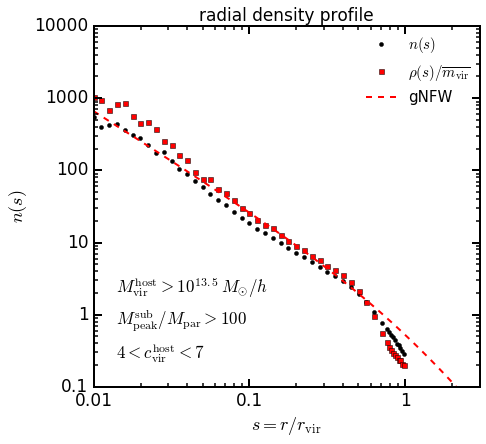

In [209]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
#golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,3.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-1,1.E4)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$n(s)$', fontsize=18)
ax.set_title(r'radial density profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.014, 2., r'$M^{\rm host}_{\rm vir}>10^{13.5}\,M_{\odot}/h$', fontsize=17)
ax.text(0.014, 0.7, r'$M^{\rm sub}_{\rm peak}/M_{\rm par}>100$', fontsize=17)
ax.text(0.014, 0.25, r'$4<c^{\rm host}_{\rm vir}<7$', fontsize=17)

ax.plot(10.**meds_logs, n_of_s, 'ko', ms=4, label=r'$n(s)$')
ax.plot(10.**meds_logs, rho_of_s[:,0]/mvir_mean_sub, 'rs', ms=5, label=r'$\rho(s)/\overline{m_{\rm vir}}$')
#ax.plot(10.**meds_logs, drhodlogs/mvir_mean_sub_sbin, 'bo-', ms=4, label=r'$\rho(s)/\overline{M_{\rm vir}(s)}$')

arr_s = 10.**np.array([-2.+0.02*i for i in xrange(151)])
ax.plot(arr_s, gNFW_rho_of_s(arr_s, gamma_bf, calR_bf)/mvir_mean_sub, 
        'r--', lw=2, label=r'gNFW')


axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/all_radial-density.png')
plt.show()

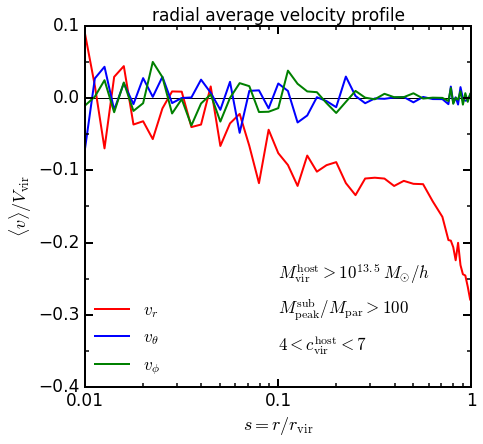

In [210]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(-0.4,0.1)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\langle v\rangle /V_{\rm vir}$', fontsize=18)
ax.set_title(r'radial average velocity profile', fontsize=17)
ax.hlines(y=0., xmin=1.E-2, xmax=1.)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)
ax.text(0.1, -0.25, r'$M^{\rm host}_{\rm vir}>10^{13.5}\,M_{\odot}/h$', fontsize=17)
ax.text(0.1, -0.3, r'$M^{\rm sub}_{\rm peak}/M_{\rm par}>100$', fontsize=17)
ax.text(0.1, -0.35, r'$4<c^{\rm host}_{\rm vir}<7$', fontsize=17)

ax.plot(10.**meds_logs, v_mean[:, 0], 'r-', lw=2, label=r'$v_{r}$')
ax.plot(10.**meds_logs, v_mean[:, 1], 'b-', lw=2, label=r'$v_{\theta}$')
ax.plot(10.**meds_logs, v_mean[:, 2], 'g-', lw=2, label=r'$v_{\phi}$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower left', numpoints=1, 
                  ncol=1, fontsize=17, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/all_radial-avevel_c4-7.png')
plt.show()

In [85]:
def get_smoothfunc(arr_D):
    func_inpspl = interpolate.InterpolatedUnivariateSpline(meds_logs, arr_D)
    sx = np.linspace(-2., 0., 70)
    sy = func_inpspl(sx)
    knots = np.array([-1.9+0.2*i for i in xrange(10)])
    return interpolate.LSQUnivariateSpline(sx,sy,knots)

In [ ]:
func_beta_std = get_smoothfunc(beta_std)

itg_beta_std = lambda x: func_beta_std(x)*np.log(10.)
betaeff_std = np.zeros(shape=(num_logsbins,))
for i in xrange(num_logsbins):
    betaeff_std[i] = integrate.quad(itg_beta_std, -1.9, meds_logs[i])[0]

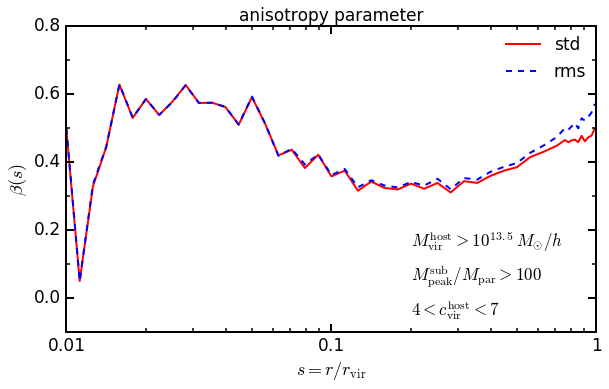

In [212]:
fig_width_pt = 700                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(-0.1,0.8)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\beta(s)$', fontsize=18)
ax.set_title(r'anisotropy parameter', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)
ax.text(0.2,  0.15, r'$M^{\rm host}_{\rm vir}>10^{13.5}\,M_{\odot}/h$', fontsize=17)
ax.text(0.2,  0.05, r'$M^{\rm sub}_{\rm peak}/M_{\rm par}>100$', fontsize=17)
ax.text(0.2, -0.05, r'$4<c^{\rm host}_{\rm vir}<7$', fontsize=17)

ax.plot(meds_s, beta_std[:], 'r-', lw=2, label=r'std')
ax.plot(meds_s, beta_rms[:], 'b--', lw=2, label=r'rms')
#ax.plot(meds_s, betaeff_std[:], 'g--', lw=2, label=r'effective')
#ax.plot(meds_s, func_beta_std(meds_logs), 'k-', lw=2, label=r'smooth')

axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=17, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/all_beta_c4-7.png')
plt.show()

In [213]:
def integrand_gNFW(q, beta, c):
    integrand = q**(2.*beta) * gNFW_rho_of_s(q, gamma_bf, calR_bf) * func_g(c)
    integrand *= -(c/q/(1.+c*q) - np.log(1.+c*q)/q**2.)
    return integrand

In [214]:
beta_mean = 0.
func_intgd_gNFW_beta0 = lambda x: integrand_gNFW(x, beta_mean, c_mean_host)
beta_mean = 0.3
func_intgd_gNFW_beta04 = lambda x: integrand_gNFW(x, beta_mean, c_mean_host)

arr_itg_constgNFW_beta0  = np.zeros(shape=(num_logsbins,))
arr_itg_constgNFW_beta04 = np.zeros(shape=(num_logsbins,))

for ibin in xrange(num_logsbins):
    beta_mean = 0.
    arr_itg_constgNFW_beta0[ibin] = (integrate.quad(func_intgd_gNFW_beta0, meds_s[ibin], 100.)[0]
                               /gNFW_rho_of_s(meds_s[ibin], gamma_bf, calR_bf)*meds_s[ibin]**(-2.*beta_mean))
    beta_mean = 0.3
    arr_itg_constgNFW_beta04[ibin] = (integrate.quad(func_intgd_gNFW_beta04, meds_s[ibin], 100.)[0]
                               /gNFW_rho_of_s(meds_s[ibin], gamma_bf, calR_bf)*meds_s[ibin]**(-2.*beta_mean))

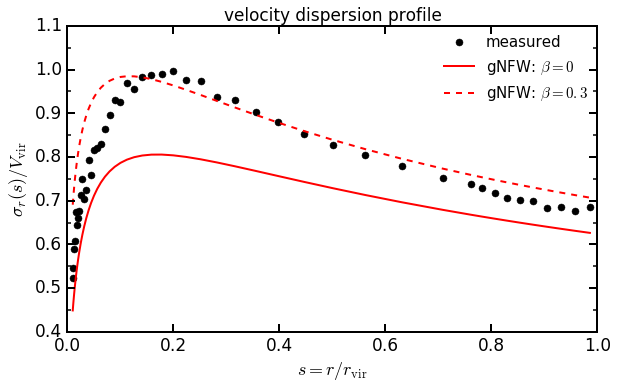

In [216]:
fig_width_pt = 700                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(0.4,1.1)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\sigma_{r}(s)/V_{\rm vir}$', fontsize=18)
ax.set_title(r'velocity dispersion profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(meds_s, v_std[:, 0], 'ko', ms=7, label=r'measured')

ax.plot(meds_s, np.sqrt(arr_itg_constgNFW_beta0[:]), 'r-', lw=2, label=r'gNFW: $\beta=0$')
ax.plot(meds_s, np.sqrt(arr_itg_constgNFW_beta04[:]), 'r--', lw=2, label=r'gNFW: $\beta=0.3$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/all_jeans_prediction_c4-7_lin.png')
plt.show()

In [217]:
func_sigmasq_smooth = get_smoothfunc(v_std[:,0]**2.)

func_log_rhosigrsq_smooth = interpolate.InterpolatedUnivariateSpline(meds_logs[:], 
                                        gNFW_rho_of_s(meds_s, gamma_bf, calR_bf)*func_sigmasq_smooth(meds_logs))
func_rho_of_s_smooth = lambda x: gNFW_rho_of_s(x, gamma_bf, calR_bf)

func_vr_smooth = get_smoothfunc(v_mean[:,0])
func_beta_std = get_smoothfunc(beta_std)

arr_1st_term = np.zeros(shape=(num_logsbins))
arr_2nd_term = np.zeros(shape=(num_logsbins))
arr_3rd_term = np.zeros(shape=(num_logsbins))
for ibin in xrange(num_logsbins):
    dlogs = 0.0001
    arr_1st_term[ibin] = (func_log_rhosigrsq_smooth(meds_logs[ibin]+dlogs/2.)
                          -func_log_rhosigrsq_smooth(meds_logs[ibin]-dlogs/2.))/dlogs/meds_s[ibin]/func_rho_of_s_smooth(meds_s[ibin])/np.log(10.)
    
    #arr_2nd_term[ibin] = 2.*func_betasigrsq_smooth(meds_logs[ibin])/meds_s[ibin]
    arr_2nd_term[ibin] = 2.*func_beta_std(meds_logs[ibin])*func_sigmasq_smooth(meds_logs[ibin])/meds_s[ibin]
    
    arr_3rd_term[ibin] = (func_vr_smooth(meds_logs[ibin]+dlogs/2.)
                          -func_vr_smooth(meds_logs[ibin]-dlogs/2.))/dlogs/meds_s[ibin]/np.log(10.)*func_vr_smooth(meds_logs[ibin])

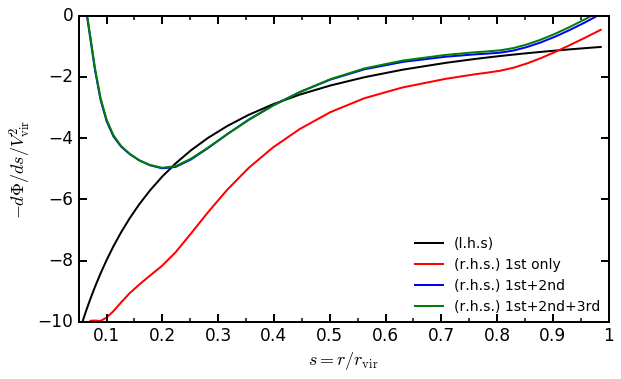

In [218]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.05,1.)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
ax.set_ylim(-10.,0.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$-d\Phi/ds/V_{\rm vir}^{2}$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, 0.05, r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)
#ax.plot(10.**stat_vel[:,0], 1.-stat_vel[:,3]**2./2./stat_vel[:,2]**2., 'k-', lw=2)

c_mean = c_mean_host
ax.plot(10.**meds_logs[:], func_minus_dPhids_perVvir2(10.**meds_logs[:], c_mean), 'k-', lw=2, label='(l.h.s)')

ax.plot(10.**meds_logs[:], arr_1st_term[:], 'r-', lw=2, label='(r.h.s.) 1st only')
#ax.plot(10.**meds_logs[:], arr_2nd_term[:], 'b--', lw=2, label='(r.h.s.) 2nd only')
ax.plot(10.**meds_logs[:], arr_1st_term[:]+arr_2nd_term[:], 'b-', lw=2, label='(r.h.s.) 1st+2nd')
ax.plot(10.**meds_logs[:], arr_1st_term[:]+arr_2nd_term[:]+arr_3rd_term[:], 
        'g-', lw=2, label='(r.h.s.) 1st+2nd+3rd')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower right', numpoints=1, 
                  ncol=1, fontsize=14, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/all_diff_Jeans_c4-7_lin.png')
plt.show()

## z_acc dependence

In [5]:
## prepare a dataset
select_Mhost = arr_subhalos['Mhost'] > 10.**13.5
## avoid incompleteness
select_Mratio = arr_subhalos['Mpeak'] > 4.5e11
select = np.logical_and(select_Mhost, select_Mratio)
arr_tmp = arr_subhalos[select]

select = np.in1d(arr_addvals['id'], arr_tmp['id'])
select_sub = np.logical_and(select, arr_addvals['upid']!=-1)
## concentration 
select_cvir = np.logical_and(arr_addvals['cvir_host'] > 4., arr_addvals['cvir_host'] < 7.)
select = np.logical_and(select_sub, select_cvir)
arr_addvals_tmp = arr_addvals[select]

arr_tmp.sort(order='id')
arr_addvals_tmp.sort(order='id')
print arr_tmp.shape[0]
print arr_addvals_tmp.shape[0]

#first rescale with rvir and Vvir
arr_addvals_tmp['Rsub'][:] = arr_addvals_tmp['Rsub'][:]/arr_addvals_tmp['rvir_host'][:]
arr_addvals_tmp['V_r'][:] = arr_addvals_tmp['V_r'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_phi'][:] = arr_addvals_tmp['V_phi'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_theta'][:] = arr_addvals_tmp['V_theta'][:]/arr_addvals_tmp['Vvir_host'][:]

A = pyfits.open(DIRNAME+'hlist_0.65650.list.all.Vpeakcut160.0.subs.fits')[1].data
select_A = np.in1d(A['id'],arr_addvals_tmp['id'])
arr_tmp2 = A[select_A]
arr_tmp2.sort(order='id')
print arr_tmp2['rvir'].mean()

dtype_add = np.dtype([('Zacc', float), ('pid', int)])
dtype_added = np.dtype(arr_addvals_tmp.dtype.descr+dtype_add.descr)

arr_addvals_zacc = np.zeros(shape=(arr_addvals_tmp.shape[0],), dtype=dtype_added)

for name in arr_addvals_tmp.names:
    arr_addvals_zacc[name][:] = arr_addvals_tmp[name][:]

arr_addvals_zacc['Zacc'][:] = 1./arr_tmp2['Acc_scale'] - 1.
arr_addvals_zacc['pid'][:] = arr_tmp2['pid']
#arr_addvals_zacc['Acc_Rate_1*Tdyn'][:] = arr_tmp2['Acc_Rate_1*Tdyn']

del arr_tmp2, A

638592
335362
203.783097865


In [7]:
A = pyfits.open(DIRNAME+'hlist_0.65650.list.all.Vpeakcut160.0.subs.fits')[1].data
print A.names
del A

['scale', 'id', 'desc_scale', 'desc_id', 'num_prog', 'pid', 'upid', 'desc_pid', 'phantom', 'sam_mvir', 'mvir', 'rvir', 'rs', 'vrms', 'mmp?', 'scale_of_last_MM', 'vmax', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Jz', 'Spin', 'Breadth_first_ID', 'Depth_first_ID', 'Tree_root_ID', 'Orig_halo_ID', 'Snap_num', 'Next_coprogenitor_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'Last_mainleaf_depthfirst_ID', 'Rs_Klypin', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'Spin_Bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer', 'Macc', 'Mpeak', 'Vacc', 'Vpeak', 'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn', 'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'Mpeak_Scale', 'Acc_Scale', 'First_Acc_Scale', 'First_Acc_Mvir', 'First_Acc_Vmax', 'Vmax@Mpeak', 'vz_host', 'Mhost', 'Vpeak_host', 'Rsub', 'Zchar', 'Zform', 'Zacc', 'Zstarve']


In [14]:
print '# of subhalos:', arr_addvals_tmp.shape[0]
print '# of sub-subs:', arr_addvals_zacc[np.logical_and(arr_addvals_zacc['upid']!=arr_addvals_zacc['pid'],
                                                        arr_addvals_zacc['upid']!=-1)].shape[0]
print '# of hosts:',arr_tmp[arr_tmp['upid']==-1].shape[0]
num_host = arr_tmp[arr_tmp['upid']==-1].shape[0]

# of subhalos: 335362
# of sub-subs: 104753
# of hosts: 75886


In [9]:
#mean subhalo mass
mvir_mean_sub = arr_addvals_tmp['mvir_sub'].mean()
print mvir_mean_sub

1.43519331265e+12


In [10]:
arr_addvals_zacc.dtype.names

('id',
 'upid',
 'sid',
 'Xsub',
 'Ysub',
 'Zsub',
 'Rsub',
 'V_r',
 'V_phi',
 'V_theta',
 'mvir_sub',
 'mvir_host',
 'rvir_host',
 'cvir_host',
 'Vvir_host',
 'Zacc',
 'pid')

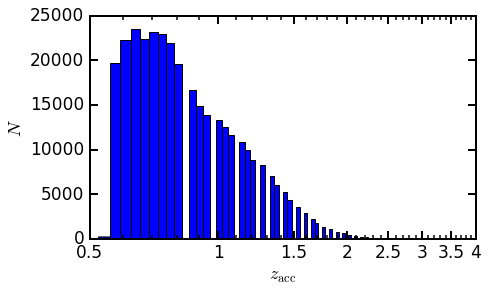

In [10]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.5,4.)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
#ax.set_ylim(0.,5.)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$z_{\rm acc}$', fontsize=18)
ax.set_ylabel(r'$N$', fontsize=18)
#ax.set_title(r'velocity dispersion profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.hist(arr_addvals_zacc['Zacc'], bins=100)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/hist_zacc.png')
plt.show()

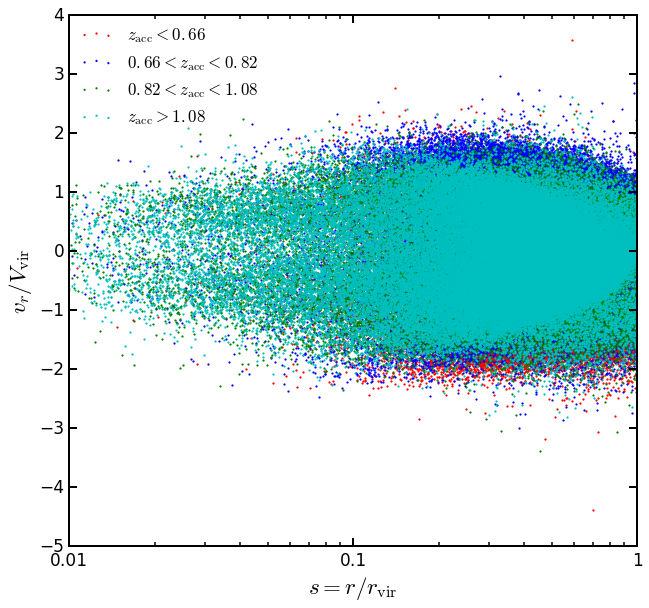

In [11]:
fig_width_pt = 750                    # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
#golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(MultipleLocator(0.1))
#ax.set_ylim(0.,5.)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=23)
ax.set_ylabel(r'$v_{r}/V_{\rm vir}$', fontsize=23)
#ax.set_title(r'velocity dispersion profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

select = arr_addvals_zacc['Zacc'][:]<0.66
plt.scatter(arr_addvals_zacc['Rsub'][select], arr_addvals_zacc['V_r'][select], 
            c='red', s=5, linewidths=0., label=r'$z_{\rm acc}<0.66$')

select = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.66,arr_addvals_zacc['Zacc'][:]<0.82)
plt.scatter(arr_addvals_zacc['Rsub'][select], arr_addvals_zacc['V_r'][select], 
            c='blue', s=5, linewidths=0., label=r'$0.66<z_{\rm acc}<0.82$')

select = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.82,arr_addvals_zacc['Zacc'][:]<1.08)
plt.scatter(arr_addvals_zacc['Rsub'][select], arr_addvals_zacc['V_r'][select], 
            c='g', s=5, linewidths=0., label=r'$0.82<z_{\rm acc}<1.08$')

select = arr_addvals_zacc['Zacc'][:]>=1.08
plt.scatter(arr_addvals_zacc['Rsub'][select], arr_addvals_zacc['V_r'][select], 
            c='c', s=5, linewidths=0., label=r'$z_{\rm acc}>1.08$')

#plt.scatter(arr_addvals_zacc['Rsub'][:], arr_addvals_zacc['V_r'][:], s=5,
#            c=arr_addvals_zacc['Zacc'][:])
#plt.colorbar()

axleg = ax.legend(loc='upper left', numpoints=1, 
                  ncol=1, fontsize=17, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

In [195]:
arr_addvals_zacc.sort(order='Zacc')
print arr_addvals_zacc['Zacc'][335362/4]
print arr_addvals_zacc['Zacc'][335362*2/4]
print arr_addvals_zacc['Zacc'][335362*3/4]
#print arr_addvals_zacc['Zacc'][746456*4/4]

0.663893510815
0.818181818182
1.079002079


### rescaled profile

In [22]:
#radial binning setting
num_logsbins = 50
dlogs = (0.5+2.)/num_logsbins
bins_logs = np.array([-2.025 + dlogs*i for i in xrange(num_logsbins+1)])
meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
meds_s = 10.**meds_logs[:]
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

In [23]:
def calc_profile(arr_addvals_tmp):
    n_of_s = np.zeros(shape=(num_logsbins))
    rho_of_s = np.zeros(shape=(num_logsbins, 2))
    v_mean = np.zeros(shape=(num_logsbins,3))
    v_std = np.zeros(shape=(num_logsbins,3))
    v_rms = np.zeros(shape=(num_logsbins,3))
    beta_std = np.zeros(shape=(num_logsbins))
    beta_rms = np.zeros(shape=(num_logsbins))

    for ibin in xrange(num_logsbins):
        select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logs[ibin], 
                                arr_addvals_tmp['Rsub']< 10.**bins_logs[ibin+1])
    
        n_of_s[ibin] = float(arr_addvals_tmp[select].shape[0])/float(num_host)/vol_logs[ibin]
        rho_of_s[ibin, 0] = np.sum(arr_addvals_tmp[select]['mvir_sub'])/float(num_host)/vol_logs[ibin]
        rho_of_s[ibin, 1] = np.sqrt(np.sum(arr_addvals_tmp[select]['mvir_sub']))/float(num_host)/vol_logs[ibin]
    
        v_mean[ibin, 0] = arr_addvals_tmp[select]['V_r'].mean()
        v_mean[ibin, 1] = arr_addvals_tmp[select]['V_theta'].mean()
        v_mean[ibin, 2] = arr_addvals_tmp[select]['V_phi'].mean()
    
        v_std[ibin, 0] = arr_addvals_tmp[select]['V_r'].std()
        v_std[ibin, 1] = arr_addvals_tmp[select]['V_theta'].std()
        v_std[ibin, 2] = arr_addvals_tmp[select]['V_phi'].std()
        
        v_rms[ibin, 0] = (arr_addvals_tmp[select]['V_r']**2.).mean()
        v_rms[ibin, 1] = (arr_addvals_tmp[select]['V_theta']**2.).mean()
        v_rms[ibin, 2] = (arr_addvals_tmp[select]['V_phi']**2.).mean()
    
        beta_std[ibin] = 1.-(v_std[ibin, 1]**2.+v_std[ibin, 2]**2.)/2./v_std[ibin, 0]**2.
        beta_rms[ibin] = 1.-(v_rms[ibin, 1] + v_rms[ibin, 2])/2./v_rms[ibin, 0]
        
    return n_of_s, rho_of_s, v_mean, v_std, v_rms, beta_std, beta_rms

In [46]:
select = arr_addvals_zacc['Zacc'][:]<0.66
n_of_s_0, rho_of_s_0, v_mean_0, v_std_0, v_rms_0, beta_std_0, beta_rms_0 = calc_profile(arr_addvals_zacc[select])

select = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.66,arr_addvals_zacc['Zacc'][:]<0.82)
n_of_s_1, rho_of_s_1, v_mean_1, v_std_1, v_rms_1, beta_std_1, beta_rms_1 = calc_profile(arr_addvals_zacc[select])

select = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.82,arr_addvals_zacc['Zacc'][:]<1.08)
n_of_s_2, rho_of_s_2, v_mean_2, v_std_2, v_rms_2, beta_std_2, beta_rms_2 = calc_profile(arr_addvals_zacc[select])

select = arr_addvals_zacc['Zacc'][:]>1.08
n_of_s_3, rho_of_s_3, v_mean_3, v_std_3, v_rms_3, beta_std_3, beta_rms_3 = calc_profile(arr_addvals_zacc[select])

/Users/ssaito/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


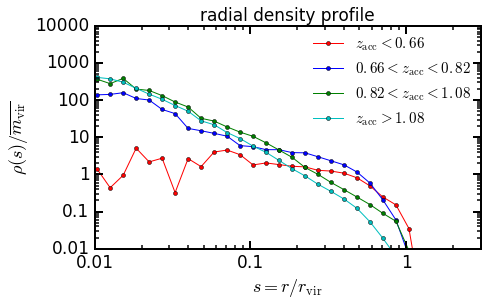

In [19]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,3.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-2,1.E4)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\rho(s)/\overline{m_{\rm vir}}$', fontsize=18)
ax.set_title(r'radial density profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.02, 0.8, r'$M^{\rm host}_{\rm vir}>10^{13.5}\,M_{\odot}/h$', fontsize=17)

#ax.plot(10.**meds_logs, n_of_s, 'ko', ms=4, label=r'$n(s)$')
ax.plot(10.**meds_logs, rho_of_s_0[:,0]/mvir_mean_sub, 'ro-', ms=4, label=r'$z_{\rm acc}<0.66$')
ax.plot(10.**meds_logs, rho_of_s_1[:,0]/mvir_mean_sub, 'bo-', ms=4, label=r'$0.66<z_{\rm acc}<0.82$')
ax.plot(10.**meds_logs, rho_of_s_2[:,0]/mvir_mean_sub, 'go-', ms=4, label=r'$0.82<z_{\rm acc}<1.08$')
ax.plot(10.**meds_logs, rho_of_s_3[:,0]/mvir_mean_sub, 'co-', ms=4, label=r'$z_{\rm acc}>1.08$')


#ax.plot(10.**meds_logs, drhodlogs/mvir_mean_sub_sbin, 'bo-', ms=4, label=r'$\rho(s)/\overline{M_{\rm vir}(s)}$')
#ax.plot(10.**meds_logs, Norm_NFW*rhoNFW_unnormalized(meds_s, c_mean)/mvir_mean_sub, 'k-', lw=2, 
#       label=r'$\rho_{\rm NFW}\,(\overline{c}=5.26)$')

#arr_s = 10.**np.array([-2.+0.02*i for i in xrange(151)])
#ax.plot(arr_s, Schechter_rho_of_s(arr_s, -2.21187851, 0.49123886)/mvir_mean_sub, 
#        'k--', lw=2, label=r'Schechter')

axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/zacc_radial-density.png')
plt.show()

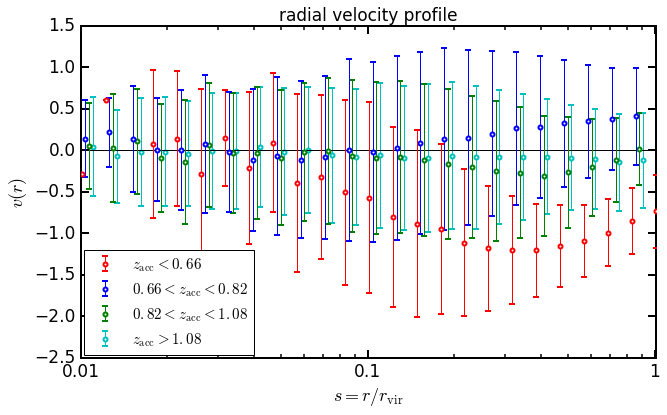

In [20]:
fig_width_pt = 760                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.01)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(-0.4,0.1)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.2))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$v(r)$', fontsize=18)
ax.set_title(r'radial velocity profile', fontsize=17)
ax.hlines(y=0., xmin=0.01, xmax=1.)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

#ax.plot(10.**meds_logs, v_mean[:, 0], 'r-', ms=4, label=r'$v_{r}$')


plt.errorbar(meds_s[:]*0.97, v_mean_0[:,0], yerr=v_std_0[:,0],
             fmt='ro', ms=4, mfc='white', mec='r', mew=2., zorder=4, label=r'$z_{\rm acc}<0.66$')

plt.errorbar(meds_s[:]*1.00, v_mean_1[:,0], yerr=v_std_1[:,0],
             fmt='bo', ms=4, mfc='white', mec='b', mew=2., zorder=3, label=r'$0.66<z_{\rm acc}<0.82$')

plt.errorbar(meds_s[:]*1.03, v_mean_2[:,0], yerr=v_std_2[:,0],
             fmt='go', ms=4, mfc='white', mec='g', mew=2., zorder=2, label=r'$0.82<z_{\rm acc}<1.08$')

plt.errorbar(meds_s[:]*1.06, v_mean_3[:,0], yerr=v_std_3[:,0],
             fmt='co', ms=4, mfc='white', mec='c', mew=2., zorder=1, label=r'$z_{\rm acc}>1.08$')

axleg = ax.legend(loc='lower left', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(True)

#plt.savefig(HOMEDIR+'Desktop/zacc_avevr.png')
plt.show()

In [24]:
select_zacc = arr_addvals_zacc['Zacc'][:] < 0.592356687898
select_Mhost = arr_addvals_zacc['mvir_host'] < 7.5666e+13
select = np.logical_and(select_zacc, select_Mhost)
vr_zacclow_Mhostlow = calc_profile(arr_addvals_zacc[select])[2]

select_zacc = arr_addvals_zacc['Zacc'][:] < 0.592356687898
select_Mhost = arr_addvals_zacc['mvir_host'] >= 7.5666e+13
select = np.logical_and(select_zacc, select_Mhost)
vr_zacclow_Mhosthigh = calc_profile(arr_addvals_zacc[select])[2]

select_zacc = arr_addvals_zacc['Zacc'][:] >= 0.592356687898
select_Mhost = arr_addvals_zacc['mvir_host'] < 7.065e+13
select = np.logical_and(select_zacc, select_Mhost)
vr_zacchigh_Mhostlow = calc_profile(arr_addvals_zacc[select])[2]

select_zacc = arr_addvals_zacc['Zacc'][:] >= 0.592356687898
select_Mhost = arr_addvals_zacc['mvir_host'] >= 7.065e+13
select = np.logical_and(select_zacc, select_Mhost)
vr_zacchigh_Mhosthigh = calc_profile(arr_addvals_zacc[select])[2]

/Users/ssaito/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


In [31]:
arr_addvals_zacc.dtype.names

('id',
 'upid',
 'sid',
 'Xsub',
 'Ysub',
 'Zsub',
 'Rsub',
 'V_r',
 'V_phi',
 'V_theta',
 'mvir_sub',
 'mvir_host',
 'rvir_host',
 'cvir_host',
 'Vvir_host',
 'Zacc',
 'pid')

In [29]:
select_zacc = arr_addvals_zacc['Zacc'][:] < 0.592356687898
print np.log10(np.mean(arr_addvals_zacc['mvir_host'][select_zacc]))

select_zacc = arr_addvals_zacc['Zacc'][:] > 1.
print np.log10(np.mean(arr_addvals_zacc['mvir_host'][select_zacc]))

14.083891777
14.0443460951


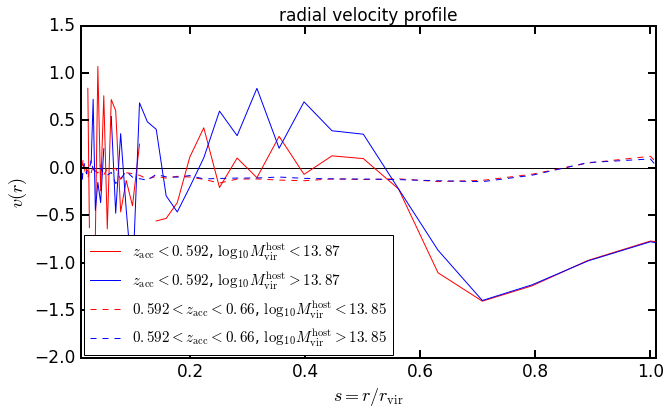

In [25]:
fig_width_pt = 760                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.01)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(-0.4,0.1)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.2))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$v(r)$', fontsize=18)
ax.set_title(r'radial velocity profile', fontsize=17)
ax.hlines(y=0., xmin=0.01, xmax=1.)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(meds_s, vr_zacclow_Mhostlow[:, 0], 'r-', ms=4, label=r'$z_{\rm acc}<0.592$, $\log_{10}M^{\rm host}_{\rm vir}<13.87$')
ax.plot(meds_s, vr_zacclow_Mhosthigh[:, 0], 'b-', ms=4, label=r'$z_{\rm acc}<0.592$, $\log_{10}M^{\rm host}_{\rm vir}>13.87$')
ax.plot(meds_s, vr_zacchigh_Mhostlow[:, 0], 'r--', ms=4, label=r'$0.592<z_{\rm acc}<0.66$, $\log_{10}M^{\rm host}_{\rm vir}<13.85$')
ax.plot(meds_s, vr_zacchigh_Mhosthigh[:, 0], 'b--', ms=4, label=r'$0.592<z_{\rm acc}<0.66$, $\log_{10}M^{\rm host}_{\rm vir}>13.85$')


#plt.errorbar(meds_s[:]*0.97, v_mean_0[:,0], yerr=v_std_0[:,0],
#             fmt='ro', ms=4, mfc='white', mec='r', mew=2., zorder=4, label=r'$z_{\rm acc}<0.66$')

#plt.errorbar(meds_s[:]*1.00, v_mean_1[:,0], yerr=v_std_1[:,0],
#             fmt='bo', ms=4, mfc='white', mec='b', mew=2., zorder=3, label=r'$0.66<z_{\rm acc}<0.82$')

#plt.errorbar(meds_s[:]*1.03, v_mean_2[:,0], yerr=v_std_2[:,0],
#             fmt='go', ms=4, mfc='white', mec='g', mew=2., zorder=2, label=r'$0.82<z_{\rm acc}<1.08$')

#plt.errorbar(meds_s[:]*1.06, v_mean_3[:,0], yerr=v_std_3[:,0],
#             fmt='co', ms=4, mfc='white', mec='c', mew=2., zorder=1, label=r'$z_{\rm acc}>1.08$')

axleg = ax.legend(loc='lower left', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(True)

#plt.savefig(HOMEDIR+'Desktop/zacc_avevr.png')
plt.show()

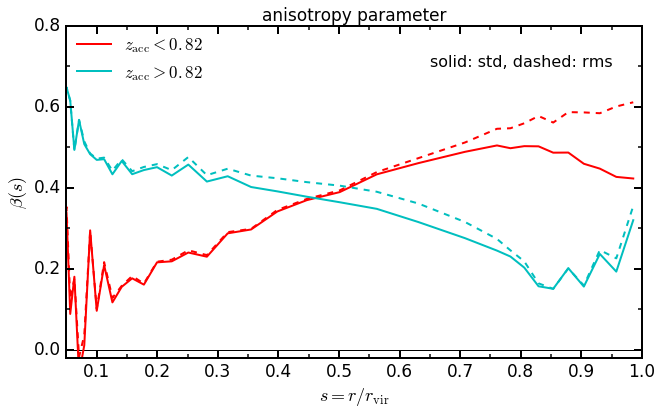

In [69]:
fig_width_pt = 760                   # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.05,1.)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(-0.02,0.8)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\beta(s)$', fontsize=18)
ax.set_title(r'anisotropy parameter', fontsize=17)
ax.hlines(y=0., xmin=0.01, xmax=1.)
ax.text(0.65, 0.7, r'solid: std, dashed: rms', fontsize=16)

ax.plot(meds_s, beta_std_0ab[:], 'r-', lw=2, label=r'$z_{\rm acc}<0.82$')
ax.plot(meds_s, beta_rms_0ab[:], 'r--', lw=2)
#ax.plot(meds_s, beta_std_1[:], 'b-', lw=2, label=r'$0.66<z_{\rm acc}<0.82$')
#ax.plot(meds_s, beta_std_2[:], 'g-', lw=2, label=r'$0.82<z_{\rm acc}<1.08$')
ax.plot(meds_s, beta_std_3ab[:], 'c-', lw=2, label=r'$z_{\rm acc}>0.82$')
ax.plot(meds_s, beta_rms_3ab[:], 'c--', lw=2)


#ax.plot(meds_s, 1.-(v_rms_0[:,1]+v_rms_0[:,2])/2./v_rms_0[:,0], 'r--', lw=2)
#ax.plot(meds_s, 1.-(v_rms_1[:,1]+v_rms_1[:,2])/2./v_rms_1[:,0], 'b--', lw=2)
#ax.plot(meds_s, 1.-(v_rms_2[:,1]+v_rms_2[:,2])/2./v_rms_2[:,0], 'g--', lw=2)
#ax.plot(meds_s, 1.-(v_rms_3[:,1]+v_rms_3[:,2])/2./v_rms_3[:,0], 'c--', lw=2)

#ax.plot(10.**meds_logs, v_mean[:, 1], 'b-', ms=4, label=r'$v_{\theta}$')
#ax.plot(10.**meds_logs, v_mean[:, 2], 'g-', ms=4, label=r'$v_{\phi}$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='upper left', numpoints=1, 
                  ncol=1, fontsize=17, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/zacc_beta_std-vs-rms.png')
plt.show()

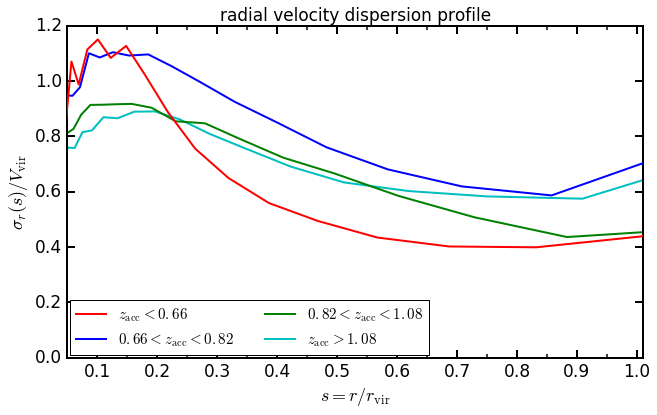

In [24]:
fig_width_pt = 760                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.05,1.01)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(-0.4,0.1)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.2))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\sigma_{r}(s)/V_{\rm vir}$', fontsize=18)
ax.set_title(r'radial velocity dispersion profile', fontsize=17)
ax.hlines(y=0., xmin=0.01, xmax=1.)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

#ax.plot(10.**meds_logs, v_mean[:, 0], 'r-', ms=4, label=r'$v_{r}$')


ax.plot(meds_s[:]*0.97, v_std_0[:,0], 'r-', lw=2, zorder=4, label=r'$z_{\rm acc}<0.66$')

ax.plot(meds_s[:]*1.00, v_std_1[:,0], 'b-', lw=2, zorder=3, label=r'$0.66<z_{\rm acc}<0.82$')

ax.plot(meds_s[:]*1.03, v_std_2[:,0], 'g-', lw=2, zorder=2, label=r'$0.82<z_{\rm acc}<1.08$')

ax.plot(meds_s[:]*1.06, v_std_3[:,0], 'c-', lw=2, zorder=1, label=r'$z_{\rm acc}>1.08$')

axleg = ax.legend(loc='lower left', numpoints=1, 
                  ncol=2, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(True)

#plt.savefig(HOMEDIR+'Desktop/zacc_sigmar.png')
plt.show()

### Jeans equation: Schechter 

In [5]:
#adoptive binning around r_vir
num_logsbins = 38 + 10
dlogs_1 = 0.05
dlogs_2 = 0.0125

bins_logs = np.zeros(shape=(num_logsbins+1,))
for ibin in xrange(num_logsbins+1):
    if ibin <= 38:
        bins_logs[ibin] = -2.025 + dlogs_1*ibin
    else:
        bins_logs[ibin] = -0.125 + dlogs_2*(ibin-38)

meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
meds_s = 10.**meds_logs[:]
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

In [31]:
select = arr_addvals_zacc['Zacc'][:]<0.66
print arr_addvals_zacc[select].shape[0]
n_of_s_0, rho_of_s_0, v_mean_0, v_std_0, v_rms_0, beta_0 = calc_profile(arr_addvals_zacc[select])

select = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.66,arr_addvals_zacc['Zacc'][:]<0.82)
print arr_addvals_zacc[select].shape[0]
n_of_s_1, rho_of_s_1, v_mean_1, v_std_1, v_rms_1, beta_1 = calc_profile(arr_addvals_zacc[select])

select = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.82,arr_addvals_zacc['Zacc'][:]<1.08)
print arr_addvals_zacc[select].shape[0]
n_of_s_2, rho_of_s_2, v_mean_2, v_std_2, v_rms_2, beta_2 = calc_profile(arr_addvals_zacc[select])

select = arr_addvals_zacc['Zacc'][:]>1.08
print arr_addvals_zacc[select].shape[0]
n_of_s_3, rho_of_s_3, v_mean_3, v_std_3, v_rms_3, beta_3 = calc_profile(arr_addvals_zacc[select])

145018
236653
188356
176429


In [16]:
from scipy.optimize import curve_fit
def Schechter_rho_of_s_0(s, alpha, s0):
    func = 10.**((alpha+1.)*(np.log10(s)-np.log10(s0)))*np.log(10)*np.exp(-s/s0)
    pivot_num = 20
    s_pivot = meds_s[pivot_num]
    func_s_at_pivot = 10.**((alpha+1.)*(np.log10(s_pivot)-np.log10(s0)))*np.log(10)*np.exp(-s_pivot/s0)
    norm = rho_of_s_0[pivot_num, 0]/func_s_at_pivot
    return func*norm

def Schechter_rho_of_s_1(s, alpha, s0):
    func = 10.**((alpha+1.)*(np.log10(s)-np.log10(s0)))*np.log(10)*np.exp(-s/s0)
    pivot_num = 20
    s_pivot = meds_s[pivot_num]
    func_s_at_pivot = 10.**((alpha+1.)*(np.log10(s_pivot)-np.log10(s0)))*np.log(10)*np.exp(-s_pivot/s0)
    norm = rho_of_s_1[pivot_num, 0]/func_s_at_pivot
    return func*norm

def Schechter_rho_of_s_2(s, alpha, s0):
    func = 10.**((alpha+1.)*(np.log10(s)-np.log10(s0)))*np.log(10)*np.exp(-s/s0)
    pivot_num = 20
    s_pivot = meds_s[pivot_num]
    func_s_at_pivot = 10.**((alpha+1.)*(np.log10(s_pivot)-np.log10(s0)))*np.log(10)*np.exp(-s_pivot/s0)
    norm = rho_of_s_2[pivot_num, 0]/func_s_at_pivot
    return func*norm

def Schechter_rho_of_s_3(s, alpha, s0):
    func = 10.**((alpha+1.)*(np.log10(s)-np.log10(s0)))*np.log(10)*np.exp(-s/s0)
    pivot_num = 20
    s_pivot = meds_s[pivot_num]
    func_s_at_pivot = 10.**((alpha+1.)*(np.log10(s_pivot)-np.log10(s0)))*np.log(10)*np.exp(-s_pivot/s0)
    norm = rho_of_s_3[pivot_num, 0]/func_s_at_pivot
    return func*norm

In [62]:
popt, pcov = curve_fit(Schechter_rho_of_s_0, meds_s[20:], rho_of_s_0[20:,0], 
                       sigma=rho_of_s_0[20:,1], bounds=([-4., 0.1], [3., 2.]))
print popt
alpha_0 = popt[0]
s_0 = popt[1]

popt, pcov = curve_fit(Schechter_rho_of_s_1, meds_s[20:], rho_of_s_1[20:,0], 
                       sigma=rho_of_s_1[20:,1], bounds=([-4., 0.1], [3., 2.]))
print popt
alpha_1 = popt[0]
s_1 = popt[1]

popt, pcov = curve_fit(Schechter_rho_of_s_2, meds_s[20:], rho_of_s_2[20:,0], 
                       sigma=rho_of_s_2[20:,1], bounds=([-4., 0.1], [3., 2.]))
print popt
alpha_2 = popt[0]
s_2 = popt[1]

popt, pcov = curve_fit(Schechter_rho_of_s_3, meds_s[20:], rho_of_s_3[20:,0], 
                       sigma=rho_of_s_3[20:,1], bounds=([-4., 0.1], [3., 2.]))
print popt
alpha_3 = popt[0]
s_3 = popt[1]

[-1.9430519   1.28084053]
[-0.79655962  0.15441951]
[-3.21675201  2.        ]
[-2.66167844  0.27047406]


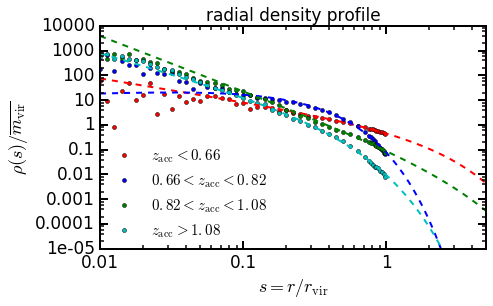

In [69]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,5.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-5,1.E4)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\rho(s)/\overline{m_{\rm vir}}$', fontsize=18)
ax.set_title(r'radial density profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.02, 0.8, r'$M^{\rm host}_{\rm vir}>10^{13.5}\,M_{\odot}/h$', fontsize=17)

#ax.plot(10.**meds_logs, n_of_s, 'ko', ms=4, label=r'$n(s)$')
ax.plot(10.**meds_logs, rho_of_s_0[:,0]/mvir_mean_sub, 'ro', ms=4, label=r'$z_{\rm acc}<0.66$')
ax.plot(10.**meds_logs, rho_of_s_1[:,0]/mvir_mean_sub, 'bo', ms=4, label=r'$0.66<z_{\rm acc}<0.82$')
ax.plot(10.**meds_logs, rho_of_s_2[:,0]/mvir_mean_sub, 'go', ms=4, label=r'$0.82<z_{\rm acc}<1.08$')
ax.plot(10.**meds_logs, rho_of_s_3[:,0]/mvir_mean_sub, 'co', ms=4, label=r'$z_{\rm acc}>1.08$')

arr_s = 10.**np.array([-2.+0.02*i for i in xrange(151)])
ax.plot(arr_s, Schechter_rho_of_s_0(arr_s, alpha_0, s_0)/mvir_mean_sub, 
        'r--', lw=2)
ax.plot(arr_s, Schechter_rho_of_s_1(arr_s, alpha_1, s_1)/mvir_mean_sub, 
        'b--', lw=2)
ax.plot(arr_s, Schechter_rho_of_s_2(arr_s, alpha_2, s_2)/mvir_mean_sub, 
        'g--', lw=2)
ax.plot(arr_s, Schechter_rho_of_s_3(arr_s, alpha_3, s_3)/mvir_mean_sub, 
        'c--', lw=2)

#ax.plot(10.**meds_logs, drhodlogs/mvir_mean_sub_sbin, 'bo-', ms=4, label=r'$\rho(s)/\overline{M_{\rm vir}(s)}$')
#ax.plot(10.**meds_logs, Norm_NFW*rhoNFW_unnormalized(meds_s, c_mean)/mvir_mean_sub, 'k-', lw=2, 
#       label=r'$\rho_{\rm NFW}\,(\overline{c}=5.26)$')

#arr_s = 10.**np.array([-2.+0.02*i for i in xrange(151)])
#ax.plot(arr_s, Schechter_rho_of_s(arr_s, -2.21187851, 0.49123886)/mvir_mean_sub, 
#        'k--', lw=2, label=r'Schechter')

axleg = ax.legend(loc='lower left', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/zacc_radial-density_Schechter.png')
plt.show()

In [51]:
def calc_sigmasqr_integratedJeans(func_Schechter_rho_of_s, beta_mean, c_mean):
    def integrand_Schechter(q, beta, c):
        integrand = q**(2.*beta) * func_Schechter_rho_of_s(q) * func_g(c)
        integrand *= -(c/q/(1.+c*q) - np.log(1.+c*q)/q**2.)
        return integrand

    func_intgd = lambda x: integrand_Schechter(x, beta_mean, c_mean)
    
    arr_itg_constbeta = np.zeros(shape=(num_logsbins,))
    for ibin in xrange(num_logsbins):
        arr_itg_constbeta[ibin] = integrate.quad(func_intgd, meds_s[ibin], 5.)[0]/func_Schechter_rho_of_s(meds_s[ibin])*meds_s[ibin]**(-2.*beta_mean)
    
    return arr_itg_constbeta

In [64]:
beta_mean = -0.7
func_Schechter_rho_of_s = lambda x: Schechter_rho_of_s_0(x, alpha_0, s_0)
arr_itg_0 = calc_sigmasqr_integratedJeans(func_Schechter_rho_of_s, beta_mean, c_mean)

beta_mean = 0.1
func_Schechter_rho_of_s = lambda x: Schechter_rho_of_s_1(x, alpha_1, s_1)
arr_itg_1 = calc_sigmasqr_integratedJeans(func_Schechter_rho_of_s, beta_mean, c_mean)

beta_mean = 0.2
func_Schechter_rho_of_s = lambda x: Schechter_rho_of_s_2(x, alpha_2, s_2)
arr_itg_2 = calc_sigmasqr_integratedJeans(func_Schechter_rho_of_s, beta_mean, c_mean)

beta_mean = 0.3
func_Schechter_rho_of_s = lambda x: Schechter_rho_of_s_3(x, alpha_3, s_3)
arr_itg_3 = calc_sigmasqr_integratedJeans(func_Schechter_rho_of_s, beta_mean, c_mean)

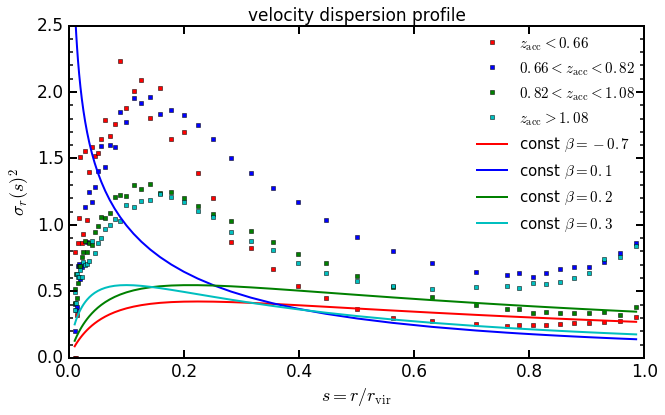

In [68]:
fig_width_pt = 760                   # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(0.,2.5)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\sigma_{r}(s)^{2}$', fontsize=18)
ax.set_title(r'velocity dispersion profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(meds_s, v_std_0[:, 0]**2., 'rs', ms=4, label=r'$z_{\rm acc}<0.66$')
ax.plot(meds_s, v_std_1[:, 0]**2., 'bs', ms=4, label=r'$0.66<z_{\rm acc}<0.82$')
ax.plot(meds_s, v_std_2[:, 0]**2., 'gs', ms=4, label=r'$0.82<z_{\rm acc}<1.08$')
ax.plot(meds_s, v_std_3[:, 0]**2., 'cs', ms=4, label=r'$z_{\rm acc}>1.08$')
ax.plot(meds_s, arr_itg_0[:], 'r-', lw=2, label=r'const $\beta=-0.7$')
ax.plot(meds_s, arr_itg_1[:], 'b-', lw=2, label=r'const $\beta=0.1$')
ax.plot(meds_s, arr_itg_2[:], 'g-', lw=2, label=r'const $\beta=0.2$')
ax.plot(meds_s, arr_itg_3[:], 'c-', lw=2, label=r'const $\beta=0.3$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/zacc_jeans_prediction_lin.png')
plt.show()

### Jeans equation: gNFW

In [49]:
#adoptive binning around r_vir
num_logsbins = 38 + 10
dlogs_1 = 0.05
dlogs_2 = 0.0125

bins_logs = np.zeros(shape=(num_logsbins+1,))
for ibin in xrange(num_logsbins+1):
    if ibin <= 38:
        bins_logs[ibin] = -2.025 + dlogs_1*ibin
    else:
        bins_logs[ibin] = -0.125 + dlogs_2*(ibin-38)

meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
meds_s = 10.**meds_logs[:]
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

In [58]:
np.median(arr_addvals_zacc['Zacc'][:])

0.81818181818181812

In [59]:
select = arr_addvals_zacc['Zacc'][:]<0.82
print '*** z_acc < 0.82 ***'
print '#:', arr_addvals_zacc[select].shape[0]
mvir_mean_sub_zacc0 = np.mean(arr_addvals_tmp['mvir_sub'][select])
cvir_mean_sub_zacc0 = np.mean(np.unique(arr_addvals_tmp['cvir_host'][select]))
print 'mean concentration of host halos weighted =', cvir_mean_sub_zacc0
print 'mean subhalo virial mass [Msun/h] =', mvir_mean_sub_zacc0
n_of_s_0ab, rho_of_s_0ab, v_mean_0ab, v_std_0ab, v_rms_0ab, beta_std_0ab, beta_rms_0ab = calc_profile(arr_addvals_zacc[select])

select = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.66,arr_addvals_zacc['Zacc'][:]<0.82)
print '\n*** 0.66 < z_acc < 0.82 ***'
print '#:', arr_addvals_zacc[select].shape[0]
mvir_mean_sub_zacc1 = np.mean(arr_addvals_tmp['mvir_sub'][select])
cvir_mean_sub_zacc1 = np.mean(np.unique(arr_addvals_tmp['cvir_host'][select]))
print 'mean concentration of host halos weighted =', cvir_mean_sub_zacc1
print 'mean subhalo virial mass [Msun/h] =', mvir_mean_sub_zacc1
n_of_s_1ab, rho_of_s_1ab, v_mean_1ab, v_std_1ab, v_rms_1ab, beta_std_1ab, beta_rms_1ab = calc_profile(arr_addvals_zacc[select])

select = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.82,arr_addvals_zacc['Zacc'][:]<1.08)
print '\n*** 0.82 < z_acc < 1.08 ***'
print '#:', arr_addvals_zacc[select].shape[0]
mvir_mean_sub_zacc2 = np.mean(arr_addvals_tmp['mvir_sub'][select])
cvir_mean_sub_zacc2 = np.mean(np.unique(arr_addvals_tmp['cvir_host'][select]))
print 'mean concentration of host halos weighted =', cvir_mean_sub_zacc2
print 'mean subhalo virial mass [Msun/h] =', mvir_mean_sub_zacc2
n_of_s_2ab, rho_of_s_2ab, v_mean_2ab, v_std_2ab, v_rms_2ab, beta_std_2ab, beta_rms_2ab = calc_profile(arr_addvals_zacc[select])

select = arr_addvals_zacc['Zacc'][:]>=0.82
print '\n*** z_acc > 0.82 ***'
print '#:', arr_addvals_zacc[select].shape[0]
mvir_mean_sub_zacc3 = np.mean(arr_addvals_tmp['mvir_sub'][select])
cvir_mean_sub_zacc3 = np.mean(np.unique(arr_addvals_tmp['cvir_host'][select]))
print 'mean concentration of host halos weighted =', cvir_mean_sub_zacc3
print 'mean subhalo virial mass [Msun/h] =', mvir_mean_sub_zacc3
n_of_s_3ab, rho_of_s_3ab, v_mean_3ab, v_std_3ab, v_rms_3ab, beta_std_3ab, beta_rms_3ab = calc_profile(arr_addvals_zacc[select])

*** z_acc < 0.82 ***
#: 176024
mean concentration of host halos weighted = 5.36452769939
mean subhalo virial mass [Msun/h] = 2.02730034985e+12

*** 0.66 < z_acc < 0.82 ***
#: 110185
mean concentration of host halos weighted = 5.35704706336
mean subhalo virial mass [Msun/h] = 1.79309833745e+12

*** 0.82 < z_acc < 1.08 ***
#: 82853
mean concentration of host halos weighted = 5.29760412324
mean subhalo virial mass [Msun/h] = 1.03026080427e+12

*** z_acc > 0.82 ***
#: 159338
mean concentration of host halos weighted = 5.35389243402
mean subhalo virial mass [Msun/h] = 781080363337.0


In [34]:
def gNFW_rho_of_s(s, gamma, calR, c = 5., msubvir_mean = 1.e12, pivot_num = 20, pivot_norm = 1.):
    func = (c*s/calR)**(-gamma) * (1.+c*s/calR)**(gamma-3.)
    s_pivot = meds_s[pivot_num]
    func_s_at_pivot = (c*s_pivot/calR)**(-gamma) * (1.+c*s_pivot/calR)**(gamma-3.)
    norm = pivot_norm/func_s_at_pivot/msubvir_mean
    return func*norm*msubvir_mean

In [55]:
print np.where(np.logical_and(meds_s>0.2, meds_s<0.6))[0]

[27 28 29 30 31 32 33 34 35]


In [61]:
piv_point = 27
end_point = 35
func_gNFW_rho_of_s = lambda x, gamma, calR: gNFW_rho_of_s(x, gamma, calR, cvir_mean_sub_zacc0, 
                                                          mvir_mean_sub_zacc0, piv_point, rho_of_s_0ab[piv_point,0])
popt, pcov = curve_fit(func_gNFW_rho_of_s, meds_s[piv_point:end_point], 
                       rho_of_s_0ab[piv_point:end_point,0], sigma= rho_of_s_0ab[piv_point:end_point,1], 
                       bounds=([0., 0.], [3., 10.]))
print popt
gamma_0 = popt[0]
calR_0 = popt[1]

piv_point = 27
end_point = 35
func_gNFW_rho_of_s = lambda x, gamma, calR: gNFW_rho_of_s(x, gamma, calR, cvir_mean_sub_zacc1, 
                                                          mvir_mean_sub_zacc1, piv_point, rho_of_s_1ab[piv_point,0])
popt, pcov = curve_fit(func_gNFW_rho_of_s, meds_s[piv_point:], rho_of_s_1ab[piv_point:,0], sigma= rho_of_s_1ab[piv_point:,1], 
                       bounds=([0., 0.], [3., 10.]))
print popt
gamma_1 = popt[0]
calR_1 = popt[1]

piv_point = 27
end_point = 35
func_gNFW_rho_of_s = lambda x, gamma, calR: gNFW_rho_of_s(x, gamma, calR, cvir_mean_sub_zacc2, 
                                                          mvir_mean_sub_zacc2, piv_point, rho_of_s_2ab[piv_point,0])
popt, pcov = curve_fit(func_gNFW_rho_of_s, meds_s[piv_point:], rho_of_s_2ab[piv_point:,0], sigma= rho_of_s_2ab[piv_point:,1], 
                       bounds=([0., 0.], [3., 10.]))
print popt
gamma_2 = popt[0]
calR_2 = popt[1]

piv_point = 20
end_point = 48
func_gNFW_rho_of_s = lambda x, gamma, calR: gNFW_rho_of_s(x, gamma, calR, cvir_mean_sub_zacc3, 
                                                          mvir_mean_sub_zacc3, piv_point, rho_of_s_3ab[piv_point,0])
popt, pcov = curve_fit(func_gNFW_rho_of_s, meds_s[piv_point:], rho_of_s_3ab[piv_point:,0], sigma= rho_of_s_3ab[piv_point:,1], 
                       bounds=([0., 0.], [3., 10.]))
print popt
gamma_3 = popt[0]
calR_3 = popt[1]

[  4.25989963e-14   2.44358068e+00]
[  2.57032790e-12   2.12061953e-01]
[ 1.88479187  1.75353245]
[  3.25404243e-16   1.99271904e-01]


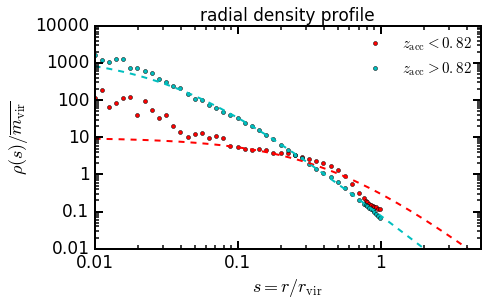

In [63]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,5.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-2,1.E4)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\rho(s)/\overline{m_{\rm vir}}$', fontsize=18)
ax.set_title(r'radial density profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.02, 0.8, r'$M^{\rm host}_{\rm vir}>10^{13.5}\,M_{\odot}/h$', fontsize=17)

#ax.plot(10.**meds_logs, n_of_s, 'ko', ms=4, label=r'$n(s)$')
ax.plot(10.**meds_logs, rho_of_s_0ab[:,0]/mvir_mean_sub_zacc0, 'ro', ms=4, label=r'$z_{\rm acc}<0.82$')
#ax.plot(10.**meds_logs, rho_of_s_1ab[:,0]/mvir_mean_sub_zacc1, 'bo', ms=4, label=r'$0.66<z_{\rm acc}<0.82$')
#ax.plot(10.**meds_logs, rho_of_s_2ab[:,0]/mvir_mean_sub_zacc2, 'go', ms=4, label=r'$0.82<z_{\rm acc}<1.08$')
ax.plot(10.**meds_logs, rho_of_s_3ab[:,0]/mvir_mean_sub_zacc3, 'co', ms=4, label=r'$z_{\rm acc}>0.82$')

arr_s = 10.**np.array([-2.+0.02*i for i in xrange(151)])
ax.plot(arr_s, gNFW_rho_of_s(arr_s, gamma_0, calR_0, cvir_mean_sub_zacc0, 
                             mvir_mean_sub_zacc0, piv_point, rho_of_s_0ab[piv_point,0])/mvir_mean_sub_zacc0, 
        'r--', lw=2)
#ax.plot(arr_s, gNFW_rho_of_s(arr_s, gamma_1, calR_1, cvir_mean_sub_zacc1, 
#                             mvir_mean_sub_zacc1, piv_point, rho_of_s_1ab[piv_point,0])/mvir_mean_sub_zacc1, 
#        'b--', lw=2)
#ax.plot(arr_s, gNFW_rho_of_s(arr_s, gamma_2, calR_2, cvir_mean_sub_zacc2, 
#                             mvir_mean_sub_zacc2, piv_point, rho_of_s_2ab[piv_point,0])/mvir_mean_sub_zacc2, 
#        'g--', lw=2)
ax.plot(arr_s, gNFW_rho_of_s(arr_s, gamma_3, calR_3, cvir_mean_sub_zacc3, 
                             mvir_mean_sub_zacc3, piv_point, rho_of_s_3ab[piv_point,0])/mvir_mean_sub_zacc3, 
        'c--', lw=2)



#ax.plot(10.**meds_logs, drhodlogs/mvir_mean_sub_sbin, 'bo-', ms=4, label=r'$\rho(s)/\overline{M_{\rm vir}(s)}$')
#ax.plot(10.**meds_logs, Norm_NFW*rhoNFW_unnormalized(meds_s, c_mean)/mvir_mean_sub, 'k-', lw=2, 
#       label=r'$\rho_{\rm NFW}\,(\overline{c}=5.26)$')

#arr_s = 10.**np.array([-2.+0.02*i for i in xrange(151)])
#ax.plot(arr_s, Schechter_rho_of_s(arr_s, -2.21187851, 0.49123886)/mvir_mean_sub, 
#        'k--', lw=2, label=r'Schechter')

axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/zacc_radial-density_Schechter.png')
plt.show()

In [72]:
def integrand_gNFW(q, beta, gamma, calR, c, mvirsub, piv_point, norm):
    integrand = q**(2.*beta)*func_g(c)*gNFW_rho_of_s(q, gamma, calR, c, mvirsub, piv_point, norm)
    integrand *= -(c/q/(1.+c*q) - np.log(1.+c*q)/q**2.)
    return integrand

In [74]:
piv_0 = 27
beta00_0 = 0.
func_itd_gNFW_beta00_0 = lambda x: integrand_gNFW(x, beta00_0, gamma_0, calR_0, cvir_mean_sub_zacc0, 
                                                  mvir_mean_sub_zacc0, piv_0, rho_of_s_0ab[piv_0,0])
beta03_0 = 0.3
func_itd_gNFW_beta03_0 = lambda x: integrand_gNFW(x, beta03_0, gamma_0, calR_0, cvir_mean_sub_zacc0, 
                                                  mvir_mean_sub_zacc0, piv_0, rho_of_s_0ab[piv_0,0])

piv_3 = 20
beta00_3 = 0.
func_itd_gNFW_beta00_3 = lambda x: integrand_gNFW(x, beta00_3, gamma_3, calR_3, cvir_mean_sub_zacc3, 
                                                  mvir_mean_sub_zacc3, piv_3, rho_of_s_3ab[piv_3,0])
beta03_3 = 0.3
func_itd_gNFW_beta03_3 = lambda x: integrand_gNFW(x, beta03_3, gamma_3, calR_3, cvir_mean_sub_zacc3, 
                                                  mvir_mean_sub_zacc3, piv_3, rho_of_s_3ab[piv_3,0])

arr_itg_constgNFW_beta00_0  = np.zeros(shape=(num_logsbins,))
arr_itg_constgNFW_beta03_0 = np.zeros(shape=(num_logsbins,))

arr_itg_constgNFW_beta00_3  = np.zeros(shape=(num_logsbins,))
arr_itg_constgNFW_beta03_3 = np.zeros(shape=(num_logsbins,))

for ibin in xrange(num_logsbins):
    arr_itg_constgNFW_beta00_0[ibin] = (integrate.quad(func_itd_gNFW_beta00_0, meds_s[ibin], 100.)[0]
                                        /gNFW_rho_of_s(meds_s[ibin], gamma_0, calR_0, cvir_mean_sub_zacc0, 
                                                       mvir_mean_sub_zacc0, piv_0, rho_of_s_0ab[piv_0,0])
                                        *meds_s[ibin]**(-2.*beta00_0))
    
    arr_itg_constgNFW_beta03_0[ibin] = (integrate.quad(func_itd_gNFW_beta03_0, meds_s[ibin], 100.)[0]
                                        /gNFW_rho_of_s(meds_s[ibin], gamma_0, calR_0, cvir_mean_sub_zacc0, 
                                                       mvir_mean_sub_zacc0, piv_0, rho_of_s_0ab[piv_0,0])
                                        *meds_s[ibin]**(-2.*beta03_0))
    
    arr_itg_constgNFW_beta00_3[ibin] = (integrate.quad(func_itd_gNFW_beta00_3, meds_s[ibin], 100.)[0]
                                        /gNFW_rho_of_s(meds_s[ibin], gamma_3, calR_3, cvir_mean_sub_zacc3, 
                                                       mvir_mean_sub_zacc3, piv_3, rho_of_s_3ab[piv_3,0])
                                        *meds_s[ibin]**(-2.*beta00_3))
    
    arr_itg_constgNFW_beta03_3[ibin] = (integrate.quad(func_itd_gNFW_beta03_3, meds_s[ibin], 100.)[0]
                                        /gNFW_rho_of_s(meds_s[ibin], gamma_3, calR_3, cvir_mean_sub_zacc3, 
                                                       mvir_mean_sub_zacc3, piv_3, rho_of_s_3ab[piv_3,0])
                                        *meds_s[ibin]**(-2.*beta03_3))
   

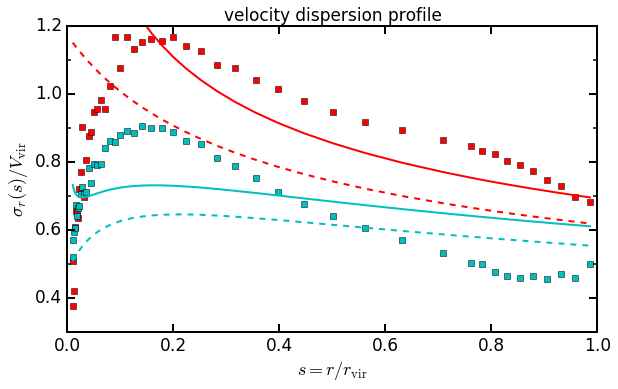

In [83]:
fig_width_pt = 700                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(0.,2.)
ax.set_ylim(0.3,1.2)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\sigma_{r}(s)/V_{\rm vir}$', fontsize=18)
ax.set_title(r'velocity dispersion profile', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(meds_s, v_std_0ab[:, 0], 'rs', ms=6, label=r'$z_{\rm acc}<0.82$')
ax.plot(meds_s, v_std_3ab[:, 0], 'cs', ms=6, label=r'$z_{\rm acc}>0.82$')

ax.plot(meds_s, np.sqrt(arr_itg_constgNFW_beta00_0[:]), 'r--', lw=2)
ax.plot(meds_s, np.sqrt(arr_itg_constgNFW_beta03_0[:]), 'r-', lw=2)

ax.plot(meds_s, np.sqrt(arr_itg_constgNFW_beta00_3[:]), 'c--', lw=2)
ax.plot(meds_s, np.sqrt(arr_itg_constgNFW_beta03_3[:]), 'c-', lw=2)
#ax.plot(meds_s, np.sqrt(arr_itg_constgNFW[:]), 'b-', lw=2, label=r'gNFW: $\beta=0.3$')
#ax.plot(meds_s, np.sqrt(arr_itg_varbeta_gNFW[:]), 'b--', lw=2, label=r'gNFW: $\beta=\beta(s)$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/all_jeans_prediction_lin.png')
plt.show()

In [97]:
func_sigmasq_smooth = get_smoothfunc(v_std_0ab[:,0]**2.)

func_log_rhosigrsq_smooth = interpolate.InterpolatedUnivariateSpline(meds_logs[:], 
                                        gNFW_rho_of_s(meds_s, gamma_0, calR_0, cvir_mean_sub_zacc0, 
                                                      mvir_mean_sub_zacc0, piv_0, rho_of_s_0ab[piv_0,0])*func_sigmasq_smooth(meds_logs))
func_rho_of_s_smooth = lambda x: gNFW_rho_of_s(x, gamma_0, calR_0, cvir_mean_sub_zacc0, 
                                                      mvir_mean_sub_zacc0, piv_0, rho_of_s_0ab[piv_0,0])

func_vr_smooth = get_smoothfunc(v_mean_0ab[:,0])
func_beta_rms = get_smoothfunc(beta_rms_0ab)

arr_1st_term = np.zeros(shape=(num_logsbins))
arr_2nd_term = np.zeros(shape=(num_logsbins))
arr_3rd_term = np.zeros(shape=(num_logsbins))
for ibin in xrange(num_logsbins):
    dlogs = 0.0001
    arr_1st_term[ibin] = (func_log_rhosigrsq_smooth(meds_logs[ibin]+dlogs/2.)
                          -func_log_rhosigrsq_smooth(meds_logs[ibin]-dlogs/2.))/dlogs/meds_s[ibin]/func_rho_of_s_smooth(meds_s[ibin])/np.log(10.)
    
    #arr_2nd_term[ibin] = 2.*func_betasigrsq_smooth(meds_logs[ibin])/meds_s[ibin]
    arr_2nd_term[ibin] = 2.*func_beta_rms(meds_logs[ibin])*func_sigmasq_smooth(meds_logs[ibin])/meds_s[ibin]
    
    arr_3rd_term[ibin] = (func_vr_smooth(meds_logs[ibin]+dlogs/2.)
                          -func_vr_smooth(meds_logs[ibin]-dlogs/2.))/dlogs/meds_s[ibin]/np.log(10.)*func_vr_smooth(meds_logs[ibin])

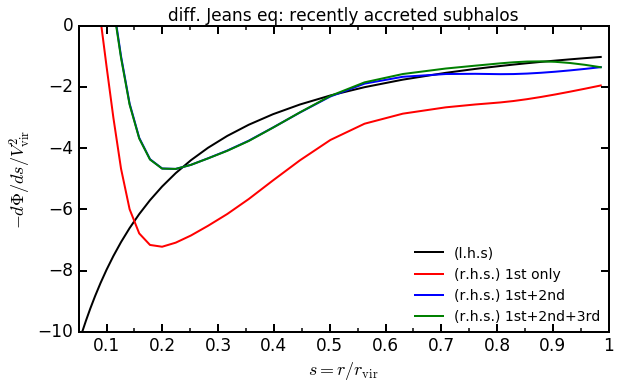

In [98]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.05,1.)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
ax.set_ylim(-10.,0.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$-d\Phi/ds/V_{\rm vir}^{2}$', fontsize=18)
ax.set_title(r'diff. Jeans eq: recently accreted subhalos', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, 0.05, r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)
#ax.plot(10.**stat_vel[:,0], 1.-stat_vel[:,3]**2./2./stat_vel[:,2]**2., 'k-', lw=2)

#c_mean = c_mean_host
ax.plot(10.**meds_logs[:], func_minus_dPhids_perVvir2(10.**meds_logs[:], cvir_mean_sub_zacc0), 'k-', lw=2, label='(l.h.s)')

ax.plot(10.**meds_logs[:], arr_1st_term[:], 'r-', lw=2, label='(r.h.s.) 1st only')
#ax.plot(10.**meds_logs[:], arr_2nd_term[:], 'b--', lw=2, label='(r.h.s.) 2nd only')
ax.plot(10.**meds_logs[:], arr_1st_term[:]+arr_2nd_term[:], 'b-', lw=2, label='(r.h.s.) 1st+2nd')
ax.plot(10.**meds_logs[:], arr_1st_term[:]+arr_2nd_term[:]+arr_3rd_term[:], 
        'g-', lw=2, label='(r.h.s.) 1st+2nd+3rd')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower right', numpoints=1, 
                  ncol=1, fontsize=14, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/all_diff_Jeans_c4-7_lin.png')
plt.show()

In [99]:
func_sigmasq_smooth = get_smoothfunc(v_std_3ab[:,0]**2.)

func_log_rhosigrsq_smooth = interpolate.InterpolatedUnivariateSpline(meds_logs[:], 
                                        gNFW_rho_of_s(meds_s, gamma_3, calR_3, cvir_mean_sub_zacc0, 
                                                      mvir_mean_sub_zacc3, piv_3, rho_of_s_3ab[piv_3,0])*func_sigmasq_smooth(meds_logs))
func_rho_of_s_smooth = lambda x: gNFW_rho_of_s(x, gamma_3, calR_3, cvir_mean_sub_zacc0, 
                                                      mvir_mean_sub_zacc3, piv_3, rho_of_s_3ab[piv_3,0])

func_vr_smooth = get_smoothfunc(v_mean_3ab[:,0])
func_beta_rms = get_smoothfunc(beta_rms_3ab)

arr_1st_term = np.zeros(shape=(num_logsbins))
arr_2nd_term = np.zeros(shape=(num_logsbins))
arr_3rd_term = np.zeros(shape=(num_logsbins))
for ibin in xrange(num_logsbins):
    dlogs = 0.0001
    arr_1st_term[ibin] = (func_log_rhosigrsq_smooth(meds_logs[ibin]+dlogs/2.)
                          -func_log_rhosigrsq_smooth(meds_logs[ibin]-dlogs/2.))/dlogs/meds_s[ibin]/func_rho_of_s_smooth(meds_s[ibin])/np.log(10.)
    
    #arr_2nd_term[ibin] = 2.*func_betasigrsq_smooth(meds_logs[ibin])/meds_s[ibin]
    arr_2nd_term[ibin] = 2.*func_beta_rms(meds_logs[ibin])*func_sigmasq_smooth(meds_logs[ibin])/meds_s[ibin]
    
    arr_3rd_term[ibin] = (func_vr_smooth(meds_logs[ibin]+dlogs/2.)
                          -func_vr_smooth(meds_logs[ibin]-dlogs/2.))/dlogs/meds_s[ibin]/np.log(10.)*func_vr_smooth(meds_logs[ibin])

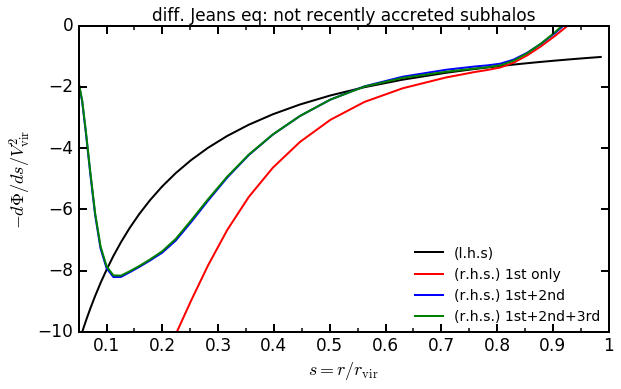

In [100]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.05,1.)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
ax.set_ylim(-10.,0.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$-d\Phi/ds/V_{\rm vir}^{2}$', fontsize=18)
ax.set_title(r'diff. Jeans eq: not recently accreted subhalos', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, 0.05, r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)
#ax.plot(10.**stat_vel[:,0], 1.-stat_vel[:,3]**2./2./stat_vel[:,2]**2., 'k-', lw=2)

#c_mean = c_mean_host
ax.plot(10.**meds_logs[:], func_minus_dPhids_perVvir2(10.**meds_logs[:], cvir_mean_sub_zacc0), 'k-', lw=2, label='(l.h.s)')

ax.plot(10.**meds_logs[:], arr_1st_term[:], 'r-', lw=2, label='(r.h.s.) 1st only')
#ax.plot(10.**meds_logs[:], arr_2nd_term[:], 'b--', lw=2, label='(r.h.s.) 2nd only')
ax.plot(10.**meds_logs[:], arr_1st_term[:]+arr_2nd_term[:], 'b-', lw=2, label='(r.h.s.) 1st+2nd')
ax.plot(10.**meds_logs[:], arr_1st_term[:]+arr_2nd_term[:]+arr_3rd_term[:], 
        'g-', lw=2, label='(r.h.s.) 1st+2nd+3rd')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower right', numpoints=1, 
                  ncol=1, fontsize=14, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/all_diff_Jeans_c4-7_lin.png')
plt.show()

### removing sub-subhalo

In [36]:
## The condition, arr_addvals_zacc['upid'] not in arr_addvals_zacc['id'], eliminates a situation like
## a subhalo is hosted by a distict host, and a sub-subhalo is hosted by the subhalo but not hosted by the distinct host.

select_zacc = arr_addvals_zacc['Zacc'][:]<0.66
select_1stsub = np.logical_and(arr_addvals_zacc['upid']==arr_addvals_zacc['pid'],
                               arr_addvals_zacc['upid'] not in arr_addvals_zacc['id'])
select = np.logical_and(select_zacc, select_1stsub)
print arr_addvals_zacc[select].shape[0]
n_of_s_0, rho_of_s_0, v_mean_0, v_std_0, v_rms_0, beta_0 = calc_profile(arr_addvals_zacc[select])

select_zacc = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.66,arr_addvals_zacc['Zacc'][:]<0.82)
select_1stsub = np.logical_and(arr_addvals_zacc['upid']==arr_addvals_zacc['pid'],
                               arr_addvals_zacc['upid'] not in arr_addvals_zacc['id'])
select = np.logical_and(select_zacc, select_1stsub)
print arr_addvals_zacc[select].shape[0]
n_of_s_1, rho_of_s_1, v_mean_1, v_std_1, v_rms_1, beta_1 = calc_profile(arr_addvals_zacc[select])

select_zacc = np.logical_and(arr_addvals_zacc['Zacc'][:]>=0.82,arr_addvals_zacc['Zacc'][:]<1.08)
select_1stsub = np.logical_and(arr_addvals_zacc['upid']==arr_addvals_zacc['pid'],
                               arr_addvals_zacc['upid'] not in arr_addvals_zacc['id'])
select = np.logical_and(select_zacc, select_1stsub)
print arr_addvals_zacc[select].shape[0]
n_of_s_2, rho_of_s_2, v_mean_2, v_std_2, v_rms_2, beta_2 = calc_profile(arr_addvals_zacc[select])

select_zacc = arr_addvals_zacc['Zacc'][:]>1.08
select_1stsub = np.logical_and(arr_addvals_zacc['upid']==arr_addvals_zacc['pid'],
                               arr_addvals_zacc['upid'] not in arr_addvals_zacc['id'])
select = np.logical_and(select_zacc, select_1stsub)
print arr_addvals_zacc[select].shape[0]
n_of_s_3, rho_of_s_3, v_mean_3, v_std_3, v_rms_3, beta_3 = calc_profile(arr_addvals_zacc[select])

118882


/Users/ssaito/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


159554
118574
97527


In [39]:
select_zacc = arr_addvals_zacc['Zacc'][:]>1.08
select_1stsub = arr_addvals_zacc['upid']==arr_addvals_zacc['pid']
select = np.logical_and(select_zacc, select_1stsub)
arr_check = arr_addvals_zacc[select]
np.where(np.in1d(arr_check['pid'], arr_addvals_zacc['id'])==True)[0].shape[0]

819

In [ ]:
##after removing sub-sub
#
#145018 -> 118882 (81.9%)
#236653 -> 159554 (67.4%)
#188356 -> 118574 (63.0%)
#176429 ->  97527 (55.3%)

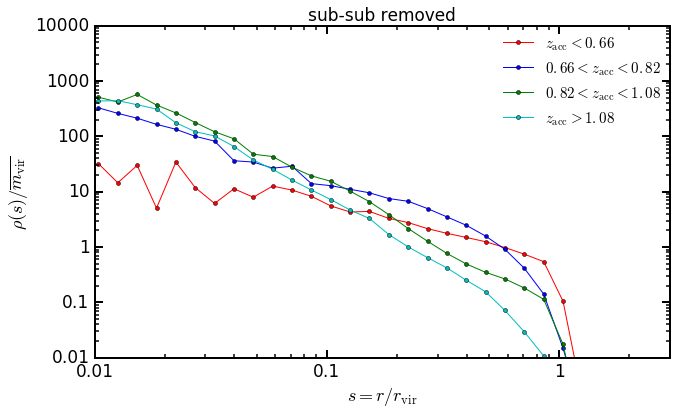

In [42]:
fig_width_pt = 760                    # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,3.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-2,1.E4)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\rho(s)/\overline{m_{\rm vir}}$', fontsize=18)
ax.set_title(r'sub-sub removed', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.02, 0.8, r'$M^{\rm host}_{\rm vir}>10^{13.5}\,M_{\odot}/h$', fontsize=17)

#ax.plot(10.**meds_logs, n_of_s, 'ko', ms=4, label=r'$n(s)$')
ax.plot(10.**meds_logs, rho_of_s_0[:,0]/mvir_mean_sub, 'ro-', ms=4, label=r'$z_{\rm acc}<0.66$')
ax.plot(10.**meds_logs, rho_of_s_1[:,0]/mvir_mean_sub, 'bo-', ms=4, label=r'$0.66<z_{\rm acc}<0.82$')
ax.plot(10.**meds_logs, rho_of_s_2[:,0]/mvir_mean_sub, 'go-', ms=4, label=r'$0.82<z_{\rm acc}<1.08$')
ax.plot(10.**meds_logs, rho_of_s_3[:,0]/mvir_mean_sub, 'co-', ms=4, label=r'$z_{\rm acc}>1.08$')


#ax.plot(10.**meds_logs, drhodlogs/mvir_mean_sub_sbin, 'bo-', ms=4, label=r'$\rho(s)/\overline{M_{\rm vir}(s)}$')
#ax.plot(10.**meds_logs, Norm_NFW*rhoNFW_unnormalized(meds_s, c_mean)/mvir_mean_sub, 'k-', lw=2, 
#       label=r'$\rho_{\rm NFW}\,(\overline{c}=5.26)$')

#arr_s = 10.**np.array([-2.+0.02*i for i in xrange(151)])
#ax.plot(arr_s, Schechter_rho_of_s(arr_s, -2.21187851, 0.49123886)/mvir_mean_sub, 
#        'k--', lw=2, label=r'Schechter')

axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/zacc_radial-density_1stsub.png')
plt.show()

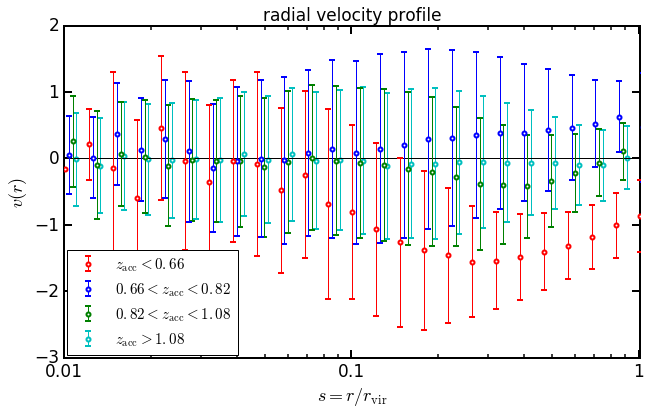

In [43]:
fig_width_pt = 760                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.01)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(-0.4,0.1)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.2))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$v(r)$', fontsize=18)
ax.set_title(r'radial velocity profile', fontsize=17)
ax.hlines(y=0., xmin=0.01, xmax=1.)
#ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

#ax.plot(10.**meds_logs, v_mean[:, 0], 'r-', ms=4, label=r'$v_{r}$')


plt.errorbar(meds_s[:]*0.97, v_mean_0[:,0], yerr=v_std_0[:,0],
             fmt='ro', ms=4, mfc='white', mec='r', mew=2., zorder=4, label=r'$z_{\rm acc}<0.66$')

plt.errorbar(meds_s[:]*1.00, v_mean_1[:,0], yerr=v_std_1[:,0],
             fmt='bo', ms=4, mfc='white', mec='b', mew=2., zorder=3, label=r'$0.66<z_{\rm acc}<0.82$')

plt.errorbar(meds_s[:]*1.03, v_mean_2[:,0], yerr=v_std_2[:,0],
             fmt='go', ms=4, mfc='white', mec='g', mew=2., zorder=2, label=r'$0.82<z_{\rm acc}<1.08$')

plt.errorbar(meds_s[:]*1.06, v_mean_3[:,0], yerr=v_std_3[:,0],
             fmt='co', ms=4, mfc='white', mec='c', mew=2., zorder=1, label=r'$z_{\rm acc}>1.08$')

axleg = ax.legend(loc='lower left', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(True)

#plt.savefig(HOMEDIR+'Desktop/zacc_avevr.png')
plt.show()

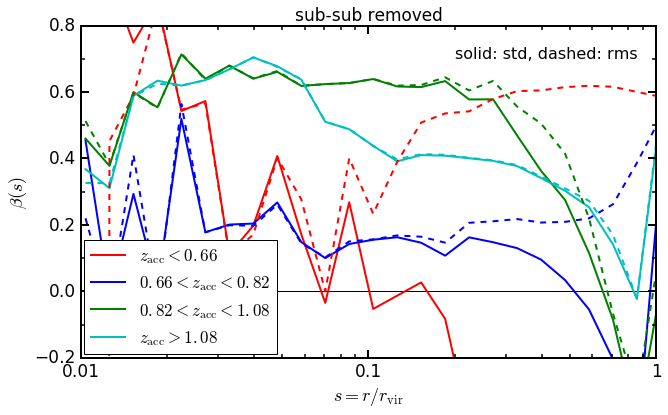

In [40]:
fig_width_pt = 760                   # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,1.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(-0.2,0.8)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$\beta(s)$', fontsize=18)
ax.set_title(r'sub-sub removed', fontsize=17)
ax.hlines(y=0., xmin=0.01, xmax=1.)
ax.text(0.2, 0.7, r'solid: std, dashed: rms', fontsize=16)

ax.plot(meds_s, beta_0[:], 'r-', lw=2, label=r'$z_{\rm acc}<0.66$')
ax.plot(meds_s, beta_1[:], 'b-', lw=2, label=r'$0.66<z_{\rm acc}<0.82$')
ax.plot(meds_s, beta_2[:], 'g-', lw=2, label=r'$0.82<z_{\rm acc}<1.08$')
ax.plot(meds_s, beta_3[:], 'c-', lw=2, label=r'$z_{\rm acc}>1.08$')


ax.plot(meds_s, 1.-(v_rms_0[:,1]+v_rms_0[:,2])/2./v_rms_0[:,0], 'r--', lw=2)
ax.plot(meds_s, 1.-(v_rms_1[:,1]+v_rms_1[:,2])/2./v_rms_1[:,0], 'b--', lw=2)
ax.plot(meds_s, 1.-(v_rms_2[:,1]+v_rms_2[:,2])/2./v_rms_2[:,0], 'g--', lw=2)
ax.plot(meds_s, 1.-(v_rms_3[:,1]+v_rms_3[:,2])/2./v_rms_3[:,0], 'c--', lw=2)

#ax.plot(10.**meds_logs, v_mean[:, 1], 'b-', ms=4, label=r'$v_{\theta}$')
#ax.plot(10.**meds_logs, v_mean[:, 2], 'g-', ms=4, label=r'$v_{\phi}$')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='lower left', numpoints=1, 
                  ncol=1, fontsize=17, borderaxespad=0.2)
axleg.draw_frame(True)

plt.savefig(HOMEDIR+'Desktop/zacc_beta_std-vs-rms_1stsub.png')
plt.show()